In [202]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.optimizers import Adam, Nadam

In [203]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

In [204]:
#from keras.utils import normalize
import os
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [205]:
import tensorflow as tf
from tensorflow.keras.metrics import *
from tensorflow.keras.layers import *
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.applications import *
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.callbacks import *
from tensorflow.keras import backend as K
#from hausdorff import hausdorff_distance
from tensorflow.keras.regularizers import l2

from sklearn.model_selection import StratifiedKFold

import os
import random
import numpy as np
from tqdm import tqdm
from skimage.io import imread,imshow
from skimage.morphology import label
from skimage.transform import resize
import matplotlib.pyplot as plt
import datetime

In [206]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.utils import plot_model

from urllib.request import urlopen
import zipfile
import imageio
import glob

In [207]:
from skimage import data
from skimage import exposure

In [208]:
cd /home/student15

/home/student15


In [209]:
ls

 anno_test.csv
 anno_train.csv
'Augment data.ipynb'
'Barlow Twin - Unet.ipynb'
'Barlow Twin - Unet_prueba1.ipynb'
'Barlow Twin - Unet_prueba1-Residual attention-Copy1.ipynb'
'Barlow Twin - Unet_prueba1-Residual attention-Copy2.ipynb'
'Barlow Twin - Unet_prueba1-Residual attention-filter-Copy1.ipynb'
'Barlow Twin - Unet_prueba1-Residual attention-filter-Copy2.ipynb'
'Barlow Twin - Unet_prueba1-Residual attention-filter.ipynb'
'Barlow Twin - Unet_prueba1-Residual attention.ipynb'
'Barlow Twin - Unet_prueba1-Residual attention_VFF_visilab_Strategy1.ipynb'
'Barlow Twin - Unet_prueba1-Residual attention_VFF_visilab_Strategy2.ipynb'
'Barlow Twin - Unet_prueba1-Residual attention_VFF_visilab_Strategy3.ipynb'
 Barlow_Twins_clasification_image_v1-Articulo-300_copia-Copy1.ipynb
 Barlow_Twins_clasification_image_v1-Articulo-300_copia-Copy2.ipynb
 Barlow_Twins_clasification_image_v1-Articulo-300_copia-Copy3.ipynb
 Barlow_Twins_clasification_image_v1-Articulo-300_copia-Copy3_PRUEBA.ipynb
 Barlow_Tw

In [210]:
################### LR SCHEDULER ###################
#SGDR: Stochastic Gradient Descent with Warm Restarts
#SGDR: Descenso de gradiente estocástico con reinicios en caliente

class WarmUpCosine(tf.keras.optimizers.schedules.LearningRateSchedule):
    """
    Implements an LR scheduler that warms up the learning rate for some training steps
    (usually at the beginning of the training) and then decays it
    with CosineDecay (see https://arxiv.org/abs/1608.03983)
    """

    def __init__(
        self, learning_rate_base, total_steps, warmup_learning_rate, warmup_steps
    ):
        super(WarmUpCosine, self).__init__()

        self.learning_rate_base = learning_rate_base
        self.total_steps = total_steps
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_steps = warmup_steps
        self.pi = tf.constant(np.pi)

    def __call__(self, step):
        if self.total_steps < self.warmup_steps:
            raise ValueError("Total_steps must be larger or equal to warmup_steps.")
        learning_rate = (
            0.5
            * self.learning_rate_base
            * (
                1
                + tf.cos(
                    self.pi
                    * (tf.cast(step, tf.float32) - self.warmup_steps)
                    / float(self.total_steps - self.warmup_steps)
                )
            )
        )

        if self.warmup_steps > 0:
            if self.learning_rate_base < self.warmup_learning_rate:
                raise ValueError(
                    "Learning_rate_base must be larger or equal to "
                    "warmup_learning_rate."
                )
            slope = (
                self.learning_rate_base - self.warmup_learning_rate
            ) / self.warmup_steps
            warmup_rate = slope * tf.cast(step, tf.float32) + self.warmup_learning_rate
            learning_rate = tf.where(
                step < self.warmup_steps, warmup_rate, learning_rate
            )
        return tf.where(
            step > self.total_steps, 0.0, learning_rate, name="learning_rate"
        )

In [211]:
################### FUNCTIONS TO CORRUPT IMAGES ###################
#FUNCIONES PARA CORRUPTAR IMÁGENES
# Transformación de las imagenes

def random_resize_crop(image, scale=[0.75, 1.0], crop_size=128):
    if crop_size == 32:
        image_shape = 48
        image = tf.image.resize(image, (image_shape, image_shape))
    else:
        image_shape = 96
        image = tf.image.resize(image, (image_shape, image_shape))
    size = tf.random.uniform(
        shape=(1,),
        minval=scale[0] * image_shape,
        maxval=scale[1] * image_shape,
        dtype=tf.float32,
    )
    size = tf.cast(size, tf.int32)[0]
    crop = tf.image.random_crop(image, (size, size, 3))
    crop_resize = tf.image.resize(crop, (crop_size, crop_size))
    return crop_resize

def flip_random_crop(image):
    image = tf.image.random_flip_left_right(image)
    image = random_resize_crop(image, crop_size=CROP_TO)
    return image

def float_parameter(level, maxval):
    return tf.cast(level * maxval / 10.0, tf.float32)

def sample_level(n):
    return tf.random.uniform(shape=[1], minval=0.1, maxval=n, dtype=tf.float32)

def rotation(image):
    augmented_image = tf.image.rot90(image)
    return augmented_image

def solarize(image, level=6):
    threshold = float_parameter(sample_level(level), 1)
    return tf.where(image < threshold, image, 255 - image)

def color_jitter(x, strength=0.5):
    x = tf.image.random_brightness(x, max_delta=0.8 * strength)
    x = tf.image.random_contrast(
        x, lower=1 - 0.8 * strength, upper=1 + 0.8 * strength
    )
    x = tf.image.random_saturation(
        x, lower=1 - 0.8 * strength, upper=1 + 0.8 * strength
    )
    x = tf.image.random_hue(x, max_delta=0.2 * strength)
    x = tf.clip_by_value(x, 0, 255)
    return x

def color_drop(x):
    x = tf.image.rgb_to_grayscale(x)
    x = tf.tile(x, [1, 1, 3])
    return x

def random_apply(func, x, p):
    if tf.random.uniform([], minval=0, maxval=1) < p:
        return func(x)
    else:
        return x

def custom_augment(image):
    
    image = tf.cast(image, tf.float32)
    image = flip_random_crop(image)
    image = random_apply(rotation, image, p=0.5)
    #image = random_apply(color_jitter, image, p=0.9)
    #image = random_apply(color_drop, image, p=0.3)
    #image = random_apply(solarize, image, p=0.3)
    return image

In [212]:
from zipfile import ZipFile
with ZipFile('dataset_cell_V6_VFFD.zip', 'r') as zf:
    zf.extractall('home/home1/student15/')

In [213]:
from zipfile import ZipFile
with ZipFile('barlow_twins_DenseNet121UNET_VFD.zip', 'r') as zf:
    zf.extractall('home/home1/student15/')

In [214]:
from zipfile import ZipFile
with ZipFile('Patch_gutta_png_prueba1_4000_D.zip', 'r') as zf:
    zf.extractall('home/home1/student15/')

In [215]:
cd /home/student15/home/home1/student15/Patch_images_gutta_png_V5

/home/student15/home/home1/student15/Patch_images_gutta_png_V5


In [216]:
ls

ejemplo.jpg  train/


In [217]:
ls

ejemplo.jpg  train/


In [218]:
import cv2
from skimage import io
from matplotlib import pyplot as plt

# Dataset

In [219]:
from skimage import io
from skimage.filters import unsharp_mask

def loadData4(folder_path):
    """
    Return a numpy array with all the png images in folder_path
    """
    
    #data_path = "Train"
    from skimage import data
    images = []
    im_paths = glob.glob(folder_path+"/*.png")
    im_paths.sort() # glob returns unordered paths
    for im_path in im_paths:
        im = cv2.imread(im_path, cv2.IMREAD_GRAYSCALE)
        #im = cv2.cvtColor(im, cv2.COLOR_GRAY2BGR)
        #im = unsharp_mask(im, radius=3, amount=1)
        im= cv2.resize(im, (256,256))
        im= np.stack((im,)*3, axis=-1)
        images.append(im)
        
        
    return np.array(images)

In [220]:
# Load data into np arrays
XX_train = loadData4("train")

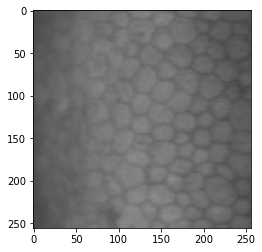

In [221]:
plt.imshow(XX_train[1], cmap='gray')

In [222]:
np.shape(XX_train)

(1719, 256, 256, 3)

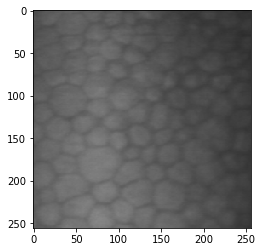

In [223]:
plt.imshow(XX_train[190], cmap='gray')

In [224]:
np.shape(XX_train[18])

(256, 256, 3)

In [225]:
np.min(XX_train[18])

74

In [226]:
# Normalise data
XX_train = XX_train.astype('float32')/255.0

In [227]:
#XX_train = np.expand_dims(XX_train,3)

In [228]:
np.shape(XX_train)

(1719, 256, 256, 3)

In [229]:
cd /home/azken/Sergio/Deformaciones_V20

[Errno 2] No such file or directory: '/home/azken/Sergio/Deformaciones_V20'
/home/student15/home/home1/student15/Patch_images_gutta_png_V5


In [230]:
cd /home/azken/Sergio/dataset_cell_V8_M

[Errno 2] No such file or directory: '/home/azken/Sergio/dataset_cell_V8_M'
/home/student15/home/home1/student15/Patch_images_gutta_png_V5


In [231]:
cd /home/azken/Sergio/dataset_cell_V6_VFFD

[Errno 2] No such file or directory: '/home/azken/Sergio/dataset_cell_V6_VFFD'
/home/student15/home/home1/student15/Patch_images_gutta_png_V5


In [232]:
cd /home/student15/home/home1/student15/dataset_cell_V6

/home/student15/home/home1/student15/dataset_cell_V6


In [233]:
ls

logs/                       result20230516-005113.png
model_Unet-without-BT.hdf5  result20230516-005138.png
result20230516-004639.png   result20230516-005812.png
result20230516-004806.png   result20230516-010216.png
result20230516-004841.png   result20230516-165922.png
result20230516-004924.png   test/
result20230516-004956.png   train/
result20230516-005026.png   Unet-without-BT.h5
result20230516-005042.png   val_complete/
result20230516-005054.png   val_patch/


In [234]:
def loadData(folder_path):
    """
    Return a numpy array with all the png images in folder_path
    """
    
    data_path = "train"
    images = []
    im_paths = glob.glob(data_path+"/"+folder_path+"/*.png")
    im_paths.sort() # glob returns unordered paths
    for im_path in im_paths:
        im = imageio.imread(im_path)
        #im = cv2.imread(im_path)
        im= cv2.resize(im, (256,256))
        if im.shape==(256,256,4):
            im=im[:,:,0]
        if im.shape==(256,256,3):
            im=im[:,:,0]
        if im.shape==(256,256):
            im=im[:,:]   
        #im = unsharp_mask(im, radius=3, amount=1)
        #im= cv2.equalizeHist(im)
        #im = unsharp_mask(im, radius=3, amount=1.0)
        im= np.stack((im,)*3, axis=-1)
        #im = exposure.equalize_adapthist(im, clip_limit=0.03)
        images.append(im)
        
        
    return np.array(images)

In [235]:
def loadData1(folder_path):
    """
    Return a numpy array with all the png images in folder_path
    """
    
    data_path = "train"
    images = []
    im_paths = glob.glob(data_path+"/"+folder_path+"/*.png")
    im_paths.sort() # glob returns unordered paths
    for im_path in im_paths:
        im = imageio.imread(im_path)
        #im = cv2.imread(im_path, cv2.IMREAD_GRAYSCALE)
        im= cv2.resize(im, (256,256))
        if im.shape==(256,256,4):
            im=im[:,:,0]
        if im.shape==(256,256,3):
            im=im[:,:,0]
        if im.shape==(256,256):
            im=im[:,:]
        #im = (im / np.max(im) * 255).astype(np.uint8)
        #im= np.stack((im,)*3, axis=-1)
        images.append(im)
        
        
    return np.array(images)

In [236]:
def loadData2(folder_path):
    """
    Return a numpy array with all the png images in folder_path
    """
    
    data_path = "test"
    images = []
    im_paths = glob.glob(data_path+"/"+folder_path+"/*.png")
    im_paths.sort() # glob returns unordered paths
    for im_path in im_paths:
        im = imageio.imread(im_path)
        #im = cv2.imread(im_path, cv2.IMREAD_GRAYSCALE)
        #im = cv2.imread(im_path)
        im= cv2.resize(im, (256,256))
        if im.shape==(256,256,4):
            im=im[:,:,0]
        #if im.shape==(256,256,3):
            #im=im[:,:,0]
        if im.shape==(256,256):
            im=im[:,:]
        #im= cv2.equalizeHist(im)
        #im = unsharp_mask(im, radius=3, amount=1)
        #im = unsharp_mask(im, radius=1, amount=1.0)
        im= np.stack((im,)*3, axis=-1)
        #im = exposure.equalize_adapthist(im, clip_limit=0.03)
        images.append(im)
        
        
    return np.array(images)

In [237]:
def loadData3(folder_path):
    """
    Return a numpy array with all the png images in folder_path
    """
    
    data_path = "test"
    images = []
    im_paths = glob.glob(data_path+"/"+folder_path+"/*.png")
    im_paths.sort() # glob returns unordered paths
    for im_path in im_paths:
        im = imageio.imread(im_path)
        #im = cv2.imread(im_path, cv2.IMREAD_GRAYSCALE)
        im= cv2.resize(im, (256,256))
        if im.shape==(256,256,4):
            im=im[:,:,0]
        if im.shape==(256,256,3):
            im=im[:,:,0]
        if im.shape==(256,256):
            im=im[:,:]
        #im= np.stack((im,)*3, axis=-1)
        #im=im*[1,1,1,1]
        images.append(im)
        
        
    return np.array(images)

In [238]:
def loadData4(folder_path):
    """
    Return a numpy array with all the png images in folder_path
    """
    
    data_path = "val_patch"
    images = []
    im_paths = glob.glob(data_path+"/"+folder_path+"/*.png")
    im_paths.sort() # glob returns unordered paths
    for im_path in im_paths:
        im = imageio.imread(im_path)
        im= cv2.resize(im, (256,256))
        if im.shape==(256,256,4):
            im=im[:,:,0]
        if im.shape==(256,256,3):
            im=im[:,:,0]
        if im.shape==(256,256):
            im=im[:,:]
        #im= cv2.equalizeHist(im)
        #im = unsharp_mask(im, radius=3, amount=1)
        #im = unsharp_mask(im, radius=1, amount=1.0)
        im= np.stack((im,)*3, axis=-1)
        #im = exposure.equalize_adapthist(im, clip_limit=0.03)
        images.append(im)
        
        
    return np.array(images)

In [239]:
def loadData5(folder_path):
    """
    Return a numpy array with all the png images in folder_path
    """
    
    data_path = "val_patch"
    images = []
    im_paths = glob.glob(data_path+"/"+folder_path+"/*.png")
    im_paths.sort() # glob returns unordered paths
    for im_path in im_paths:
        im = imageio.imread(im_path)
        im= cv2.resize(im, (256,256))
        if im.shape==(256,256,4):
            im=im[:,:,0]
        if im.shape==(256,256,3):
            im=im[:,:,0]
        if im.shape==(256,256):
            im=im[:,:]
        #im= np.stack((im,)*3, axis=-1)
        #im=im*[1,1,1,1]
        images.append(im)
        
        
    return np.array(images)

In [240]:
def loadData6(folder_path):
    """
    Return a numpy array with all the png images in folder_path
    """
    
    data_path = "val_complete"
    images = []
    im_paths = glob.glob(data_path+"/"+folder_path+"/*.png")
    im_paths.sort() # glob returns unordered paths
    for im_path in im_paths:
        im = imageio.imread(im_path)
        im= cv2.resize(im, (256,256))
        if im.shape==(256,256,4):
            im=im[:,:,0]
        if im.shape==(256,256,3):
            im=im[:,:,0]
        if im.shape==(256,256):
            im=im[:,:]
        #im = unsharp_mask(im, radius=1, amount=1.0)
        #im = unsharp_mask(im, radius=3, amount=1)
        im= np.stack((im,)*3, axis=-1)
        #im = exposure.equalize_adapthist(im, clip_limit=0.03)
        images.append(im)
        
        
    return np.array(images)

In [241]:
def loadData7(folder_path):
    """
    Return a numpy array with all the png images in folder_path
    """
    
    data_path = "val_complete"
    images = []
    im_paths = glob.glob(data_path+"/"+folder_path+"/*.png")
    im_paths.sort() # glob returns unordered paths
    for im_path in im_paths:
        im = imageio.imread(im_path)
        im= cv2.resize(im, (256,256))
        if im.shape==(256,256,4):
            im=im[:,:,0]
        if im.shape==(256,256,3):
            im=im[:,:,0]
        if im.shape==(256,256):
            im=im[:,:]
        #im= np.stack((im,)*3, axis=-1)
        #im=im*[1,1,1,1]
        images.append(im)
        
        
    return np.array(images)

In [242]:
# Load data into np arrays
X_train = loadData("images")
y_train = loadData1("masks")
X_test = loadData2("images")
y_test = loadData3("masks")
X_val_patch = loadData4("images")
y_val_patch = loadData5("masks")
X_val_complete = loadData6("images")
y_val_complete = loadData7("masks")

In [243]:
np.shape(X_test)

(25, 256, 256, 3)

In [244]:
np.shape(X_train)

(216, 256, 256, 3)

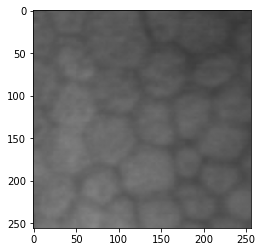

In [245]:
plt.imshow(X_train[0])

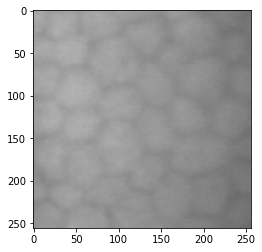

In [246]:
plt.imshow(X_test[0], cmap='gray')

In [247]:
np.max(y_train[21])

255

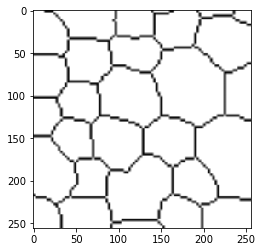

In [248]:
plt.imshow(y_train[22], cmap='gray')

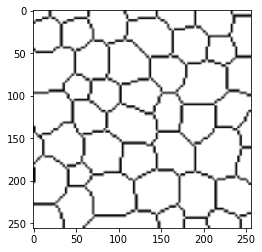

In [249]:
plt.imshow(y_test[1], cmap='gray')

In [250]:
np.max(y_test[0])

255

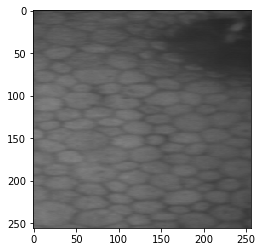

In [251]:
plt.imshow(X_val_complete[2], cmap='gray')

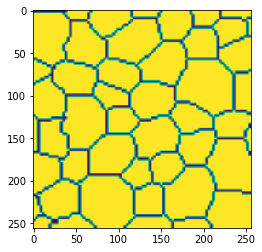

In [252]:
plt.imshow(y_train[1])

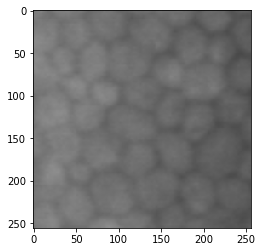

In [253]:
plt.imshow(X_test[1], cmap='gray')

In [254]:
np.shape(X_test)

(25, 256, 256, 3)

In [255]:
np.shape(y_test)

(25, 256, 256)

In [256]:
np.shape(X_train)

(216, 256, 256, 3)

In [257]:
np.shape(y_train)

(216, 256, 256)

In [258]:
np.shape(y_val_patch)

(30, 256, 256)

In [259]:
np.shape(X_val_patch)

(30, 256, 256, 3)

In [260]:
np.shape(X_val_complete)

(23, 256, 256, 3)

In [261]:
np.shape(y_val_complete)

(23, 256, 256)

In [262]:
# Normalise data
X_train = X_train.astype('float32')/255.0
X_test = X_test.astype('float32')/255.0
y_train = y_train.astype('float32')/255.0
y_test = y_test.astype('float32')/255.0

X_val_patch = X_val_patch.astype('float32')/255.0
y_val_patch = y_val_patch.astype('float32')/255.0

X_val_complete = X_val_complete/255.0
y_val_complete = y_val_complete/255.0

In [263]:
#X_train = np.expand_dims(X_train,3)
#X_test = np.expand_dims(X_test,3)
y_train = np.expand_dims(y_train,3)
y_test = np.expand_dims(y_test,3)

y_val_patch = np.expand_dims(y_val_patch,3)
#y_val_complete = np.expand_dims(y_val_complete,3)

In [264]:
np.shape(X_train)

(216, 256, 256, 3)

In [265]:
np.shape(y_train)

(216, 256, 256, 1)

In [266]:
np.shape(X_test)

(25, 256, 256, 3)

In [267]:
np.shape(y_test)

(25, 256, 256, 1)

In [268]:
np.shape(X_val_patch)

(30, 256, 256, 3)

In [269]:
np.shape(y_val_patch)

(30, 256, 256, 1)

In [270]:
np.shape(X_val_complete)

(23, 256, 256, 3)

In [271]:
np.shape(y_val_complete)

(23, 256, 256)

In [272]:
IMG_HEIGHT = 256
IMG_WIDTH = 256
IMG_CHANNELS = 3

In [273]:
AUTO = tf.data.experimental.AUTOTUNE

In [274]:
np.shape(XX_train)

(1719, 256, 256, 3)

In [275]:
################### CORRUPTING DATA FOR PRE-TRAINING ###################
# CORRUPCIÓN DE DATOS PARA ENTRENAMIENTO PREVIO

AUTO = tf.data.experimental.AUTOTUNE
CROP_TO = IMG_HEIGHT
SEED = 42
BATCH_SIZE = 8


ssl_ds_one = tf.data.Dataset.from_tensor_slices(XX_train)


ssl_ds_one = (
    ssl_ds_one.shuffle(1024, seed=SEED)
    .map(custom_augment, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

ssl_ds_two = tf.data.Dataset.from_tensor_slices(XX_train)
ssl_ds_two = (
    ssl_ds_two.shuffle(1024, seed=SEED)
    .map(custom_augment, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)


ssl_ds = tf.data.Dataset.zip((ssl_ds_one, ssl_ds_two))

# Grafica del par de imagen ssl_ds_one

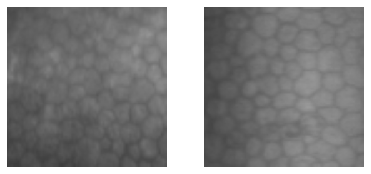

In [276]:
sample_images_one = next(iter(ssl_ds_one))
plt.figure(figsize=(10, 10))
for n in range(2):
    ax = plt.subplot(3, 3, n + 1)
    m= sample_images_one[n]
    #m= np.array(m,np.int32)
    plt.imshow(m)
    #print(sample_images_one[n].numpy().shape)
    plt.axis("off")
plt.show()

# Grafica del par de imagen ssl_ds_two

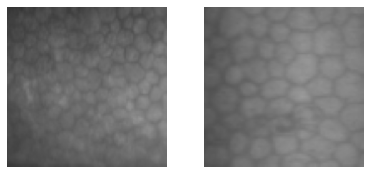

In [277]:
sample_images_two = next(iter(ssl_ds_two))
plt.figure(figsize=(10, 10))
for n in range(2):
    ax = plt.subplot(3, 3, n + 1)
    m= sample_images_two[n]
    #m= np.array(m,np.int32)
    plt.imshow(m)
    #print(sample_images_one[n].numpy().shape)
    plt.axis("off")
plt.show()

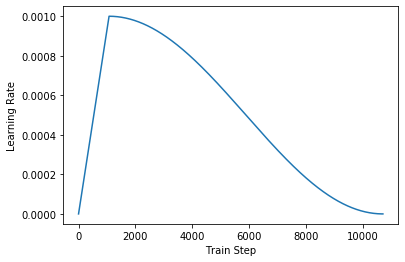

In [278]:
################### SETUP BARLOW TWINS ###################
def off_diagonal(x):
    n = tf.shape(x)[0]
    flattened = tf.reshape(x, [-1])[:-1] # Convierte la matriz X en un vector.
    off_diagonals = tf.reshape(flattened, (n-1, n+1))[:, 1:]
    return tf.reshape(off_diagonals, [-1])


def normalize_repr(z):
    z_norm = (z - tf.reduce_mean(z, axis=0)) / tf.math.reduce_std(z, axis=0)
    return z_norm


def compute_loss(z_a, z_b, lambd):
    # Get batch size and representation dimension.
    batch_size = tf.cast(tf.shape(z_a)[0], z_a.dtype)
    repr_dim = tf.shape(z_a)[1]

    # Normalize the representations along the batch dimension.
    z_a_norm = normalize_repr(z_a)
    z_b_norm = normalize_repr(z_b)

    # Cross-correlation matrix.
    c = tf.matmul(z_a_norm, z_b_norm, transpose_a=True) / batch_size

    # Loss.
    on_diag = tf.linalg.diag_part(c) + (-1)
    on_diag = tf.reduce_sum(tf.pow(on_diag, 2))
    off_diag = off_diagonal(c)
    off_diag = tf.reduce_sum(tf.pow(off_diag, 2))
    loss = on_diag + (lambd * off_diag)
    return loss 

class BarlowTwins(tf.keras.Model):
    def __init__(self, encoder, lambd=5e-3):
        super(BarlowTwins, self).__init__()
        self.encoder = encoder
        self.lambd = lambd
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")

    @property
    def metrics(self):
        return [self.loss_tracker]

    def train_step(self, data):
        # Unpack the data.
        ds_one, ds_two = data

        # Forward pass through the encoder and predictor.
        with tf.GradientTape() as tape:
            z_a, z_b = self.encoder(ds_one, training=True), self.encoder(ds_two, training=True)
            loss = compute_loss(z_a, z_b, self.lambd) 

        # Compute gradients and update the parameters.
        gradients = tape.gradient(loss, self.encoder.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.encoder.trainable_variables))

        # Monitor loss.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

PROJECT_DIM = IMG_HEIGHT
BATCH_SIZE = 8
EPOCHS = 50
WEIGHT_DECAY = 5e-4

STEPS_PER_EPOCH = len(XX_train) // BATCH_SIZE
TOTAL_STEPS = STEPS_PER_EPOCH * EPOCHS
WARMUP_EPOCHS = int(EPOCHS * 0.1)
WARMUP_STEPS = int(WARMUP_EPOCHS * STEPS_PER_EPOCH)

lr_decayed_fn = WarmUpCosine(
    learning_rate_base=1e-3,
    total_steps=EPOCHS * STEPS_PER_EPOCH,
    warmup_learning_rate=0.0,
    warmup_steps=WARMUP_STEPS
)

plt.plot(lr_decayed_fn(tf.range(EPOCHS*STEPS_PER_EPOCH, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")
plt.show()

In [279]:
################### FUNCTIONS TO DEVELOP U-NET MODEL ###################
# Aquí se acondiciona el vector de entrada a la red Unet
def expend_as(tensor, rep):
     return Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3),
                          arguments={'repnum': rep})(tensor)

In [280]:
def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def decoder_block(inputs, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(inputs)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

In [281]:
def projection_head(x, hidden_dim=128):
    """Constructs the projection head."""
    for i in range(2):
        x = Dense(
            hidden_dim,
            name=f"projection_layer_{i}",
            kernel_regularizer=l2(WEIGHT_DECAY),
        )(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
    outputs = Dense(hidden_dim, name="projection_output")(x)
    return outputs

In [282]:
# correr buil encoder

In [283]:
def build_encoder_densenet121_unet(shape, hidden_dim=128):
    """ Input """
    inputs = Input(shape)

    """ Pre-trained DenseNet121 Model """
    densenet = DenseNet121(include_top=False, weights="imagenet", input_tensor=inputs)

    """ Encoder """
    s1 = densenet.get_layer("input_1").output       ## 256
    s2 = densenet.get_layer("conv1/relu").output    ## 128
    s3 = densenet.get_layer("pool2_relu").output ## 64
    s4 = densenet.get_layer("pool3_relu").output  ## 32

    """ Bridge """
    b1 = densenet.get_layer("pool4_relu").output  ## 32
    
    # Projections
    trunk_output = GlobalAvgPool2D()(b1)
    projection_outputs = projection_head(trunk_output, hidden_dim=hidden_dim)

    """ Outputs """
        
    model = Model(inputs, projection_outputs, name="DenseNet121_U-Net")
    return model

In [284]:
def build_DenseNet121_unet(shape, hidden_dim=128):
    """ Decoder """
    d1 = decoder_block(b1, s4, 128)             ## 64
    d2 = decoder_block(d1, s3, 64)             ## 128
    d3 = decoder_block(d2, s2, 32)             ## 256
    d4 = decoder_block(d3, s1, 16)              ## 512

    """ Outputs """
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs)
    return model

In [285]:
unet_enc = build_encoder_densenet121_unet((256, 256, 3), hidden_dim=PROJECT_DIM)

ValueError: No such layer: input_1. Existing layers are: ['input_3', 'zero_padding2d_4', 'conv1/conv', 'conv1/bn', 'conv1/relu', 'zero_padding2d_5', 'pool1', 'conv2_block1_0_bn', 'conv2_block1_0_relu', 'conv2_block1_1_conv', 'conv2_block1_1_bn', 'conv2_block1_1_relu', 'conv2_block1_2_conv', 'conv2_block1_concat', 'conv2_block2_0_bn', 'conv2_block2_0_relu', 'conv2_block2_1_conv', 'conv2_block2_1_bn', 'conv2_block2_1_relu', 'conv2_block2_2_conv', 'conv2_block2_concat', 'conv2_block3_0_bn', 'conv2_block3_0_relu', 'conv2_block3_1_conv', 'conv2_block3_1_bn', 'conv2_block3_1_relu', 'conv2_block3_2_conv', 'conv2_block3_concat', 'conv2_block4_0_bn', 'conv2_block4_0_relu', 'conv2_block4_1_conv', 'conv2_block4_1_bn', 'conv2_block4_1_relu', 'conv2_block4_2_conv', 'conv2_block4_concat', 'conv2_block5_0_bn', 'conv2_block5_0_relu', 'conv2_block5_1_conv', 'conv2_block5_1_bn', 'conv2_block5_1_relu', 'conv2_block5_2_conv', 'conv2_block5_concat', 'conv2_block6_0_bn', 'conv2_block6_0_relu', 'conv2_block6_1_conv', 'conv2_block6_1_bn', 'conv2_block6_1_relu', 'conv2_block6_2_conv', 'conv2_block6_concat', 'pool2_bn', 'pool2_relu', 'pool2_conv', 'pool2_pool', 'conv3_block1_0_bn', 'conv3_block1_0_relu', 'conv3_block1_1_conv', 'conv3_block1_1_bn', 'conv3_block1_1_relu', 'conv3_block1_2_conv', 'conv3_block1_concat', 'conv3_block2_0_bn', 'conv3_block2_0_relu', 'conv3_block2_1_conv', 'conv3_block2_1_bn', 'conv3_block2_1_relu', 'conv3_block2_2_conv', 'conv3_block2_concat', 'conv3_block3_0_bn', 'conv3_block3_0_relu', 'conv3_block3_1_conv', 'conv3_block3_1_bn', 'conv3_block3_1_relu', 'conv3_block3_2_conv', 'conv3_block3_concat', 'conv3_block4_0_bn', 'conv3_block4_0_relu', 'conv3_block4_1_conv', 'conv3_block4_1_bn', 'conv3_block4_1_relu', 'conv3_block4_2_conv', 'conv3_block4_concat', 'conv3_block5_0_bn', 'conv3_block5_0_relu', 'conv3_block5_1_conv', 'conv3_block5_1_bn', 'conv3_block5_1_relu', 'conv3_block5_2_conv', 'conv3_block5_concat', 'conv3_block6_0_bn', 'conv3_block6_0_relu', 'conv3_block6_1_conv', 'conv3_block6_1_bn', 'conv3_block6_1_relu', 'conv3_block6_2_conv', 'conv3_block6_concat', 'conv3_block7_0_bn', 'conv3_block7_0_relu', 'conv3_block7_1_conv', 'conv3_block7_1_bn', 'conv3_block7_1_relu', 'conv3_block7_2_conv', 'conv3_block7_concat', 'conv3_block8_0_bn', 'conv3_block8_0_relu', 'conv3_block8_1_conv', 'conv3_block8_1_bn', 'conv3_block8_1_relu', 'conv3_block8_2_conv', 'conv3_block8_concat', 'conv3_block9_0_bn', 'conv3_block9_0_relu', 'conv3_block9_1_conv', 'conv3_block9_1_bn', 'conv3_block9_1_relu', 'conv3_block9_2_conv', 'conv3_block9_concat', 'conv3_block10_0_bn', 'conv3_block10_0_relu', 'conv3_block10_1_conv', 'conv3_block10_1_bn', 'conv3_block10_1_relu', 'conv3_block10_2_conv', 'conv3_block10_concat', 'conv3_block11_0_bn', 'conv3_block11_0_relu', 'conv3_block11_1_conv', 'conv3_block11_1_bn', 'conv3_block11_1_relu', 'conv3_block11_2_conv', 'conv3_block11_concat', 'conv3_block12_0_bn', 'conv3_block12_0_relu', 'conv3_block12_1_conv', 'conv3_block12_1_bn', 'conv3_block12_1_relu', 'conv3_block12_2_conv', 'conv3_block12_concat', 'pool3_bn', 'pool3_relu', 'pool3_conv', 'pool3_pool', 'conv4_block1_0_bn', 'conv4_block1_0_relu', 'conv4_block1_1_conv', 'conv4_block1_1_bn', 'conv4_block1_1_relu', 'conv4_block1_2_conv', 'conv4_block1_concat', 'conv4_block2_0_bn', 'conv4_block2_0_relu', 'conv4_block2_1_conv', 'conv4_block2_1_bn', 'conv4_block2_1_relu', 'conv4_block2_2_conv', 'conv4_block2_concat', 'conv4_block3_0_bn', 'conv4_block3_0_relu', 'conv4_block3_1_conv', 'conv4_block3_1_bn', 'conv4_block3_1_relu', 'conv4_block3_2_conv', 'conv4_block3_concat', 'conv4_block4_0_bn', 'conv4_block4_0_relu', 'conv4_block4_1_conv', 'conv4_block4_1_bn', 'conv4_block4_1_relu', 'conv4_block4_2_conv', 'conv4_block4_concat', 'conv4_block5_0_bn', 'conv4_block5_0_relu', 'conv4_block5_1_conv', 'conv4_block5_1_bn', 'conv4_block5_1_relu', 'conv4_block5_2_conv', 'conv4_block5_concat', 'conv4_block6_0_bn', 'conv4_block6_0_relu', 'conv4_block6_1_conv', 'conv4_block6_1_bn', 'conv4_block6_1_relu', 'conv4_block6_2_conv', 'conv4_block6_concat', 'conv4_block7_0_bn', 'conv4_block7_0_relu', 'conv4_block7_1_conv', 'conv4_block7_1_bn', 'conv4_block7_1_relu', 'conv4_block7_2_conv', 'conv4_block7_concat', 'conv4_block8_0_bn', 'conv4_block8_0_relu', 'conv4_block8_1_conv', 'conv4_block8_1_bn', 'conv4_block8_1_relu', 'conv4_block8_2_conv', 'conv4_block8_concat', 'conv4_block9_0_bn', 'conv4_block9_0_relu', 'conv4_block9_1_conv', 'conv4_block9_1_bn', 'conv4_block9_1_relu', 'conv4_block9_2_conv', 'conv4_block9_concat', 'conv4_block10_0_bn', 'conv4_block10_0_relu', 'conv4_block10_1_conv', 'conv4_block10_1_bn', 'conv4_block10_1_relu', 'conv4_block10_2_conv', 'conv4_block10_concat', 'conv4_block11_0_bn', 'conv4_block11_0_relu', 'conv4_block11_1_conv', 'conv4_block11_1_bn', 'conv4_block11_1_relu', 'conv4_block11_2_conv', 'conv4_block11_concat', 'conv4_block12_0_bn', 'conv4_block12_0_relu', 'conv4_block12_1_conv', 'conv4_block12_1_bn', 'conv4_block12_1_relu', 'conv4_block12_2_conv', 'conv4_block12_concat', 'conv4_block13_0_bn', 'conv4_block13_0_relu', 'conv4_block13_1_conv', 'conv4_block13_1_bn', 'conv4_block13_1_relu', 'conv4_block13_2_conv', 'conv4_block13_concat', 'conv4_block14_0_bn', 'conv4_block14_0_relu', 'conv4_block14_1_conv', 'conv4_block14_1_bn', 'conv4_block14_1_relu', 'conv4_block14_2_conv', 'conv4_block14_concat', 'conv4_block15_0_bn', 'conv4_block15_0_relu', 'conv4_block15_1_conv', 'conv4_block15_1_bn', 'conv4_block15_1_relu', 'conv4_block15_2_conv', 'conv4_block15_concat', 'conv4_block16_0_bn', 'conv4_block16_0_relu', 'conv4_block16_1_conv', 'conv4_block16_1_bn', 'conv4_block16_1_relu', 'conv4_block16_2_conv', 'conv4_block16_concat', 'conv4_block17_0_bn', 'conv4_block17_0_relu', 'conv4_block17_1_conv', 'conv4_block17_1_bn', 'conv4_block17_1_relu', 'conv4_block17_2_conv', 'conv4_block17_concat', 'conv4_block18_0_bn', 'conv4_block18_0_relu', 'conv4_block18_1_conv', 'conv4_block18_1_bn', 'conv4_block18_1_relu', 'conv4_block18_2_conv', 'conv4_block18_concat', 'conv4_block19_0_bn', 'conv4_block19_0_relu', 'conv4_block19_1_conv', 'conv4_block19_1_bn', 'conv4_block19_1_relu', 'conv4_block19_2_conv', 'conv4_block19_concat', 'conv4_block20_0_bn', 'conv4_block20_0_relu', 'conv4_block20_1_conv', 'conv4_block20_1_bn', 'conv4_block20_1_relu', 'conv4_block20_2_conv', 'conv4_block20_concat', 'conv4_block21_0_bn', 'conv4_block21_0_relu', 'conv4_block21_1_conv', 'conv4_block21_1_bn', 'conv4_block21_1_relu', 'conv4_block21_2_conv', 'conv4_block21_concat', 'conv4_block22_0_bn', 'conv4_block22_0_relu', 'conv4_block22_1_conv', 'conv4_block22_1_bn', 'conv4_block22_1_relu', 'conv4_block22_2_conv', 'conv4_block22_concat', 'conv4_block23_0_bn', 'conv4_block23_0_relu', 'conv4_block23_1_conv', 'conv4_block23_1_bn', 'conv4_block23_1_relu', 'conv4_block23_2_conv', 'conv4_block23_concat', 'conv4_block24_0_bn', 'conv4_block24_0_relu', 'conv4_block24_1_conv', 'conv4_block24_1_bn', 'conv4_block24_1_relu', 'conv4_block24_2_conv', 'conv4_block24_concat', 'pool4_bn', 'pool4_relu', 'pool4_conv', 'pool4_pool', 'conv5_block1_0_bn', 'conv5_block1_0_relu', 'conv5_block1_1_conv', 'conv5_block1_1_bn', 'conv5_block1_1_relu', 'conv5_block1_2_conv', 'conv5_block1_concat', 'conv5_block2_0_bn', 'conv5_block2_0_relu', 'conv5_block2_1_conv', 'conv5_block2_1_bn', 'conv5_block2_1_relu', 'conv5_block2_2_conv', 'conv5_block2_concat', 'conv5_block3_0_bn', 'conv5_block3_0_relu', 'conv5_block3_1_conv', 'conv5_block3_1_bn', 'conv5_block3_1_relu', 'conv5_block3_2_conv', 'conv5_block3_concat', 'conv5_block4_0_bn', 'conv5_block4_0_relu', 'conv5_block4_1_conv', 'conv5_block4_1_bn', 'conv5_block4_1_relu', 'conv5_block4_2_conv', 'conv5_block4_concat', 'conv5_block5_0_bn', 'conv5_block5_0_relu', 'conv5_block5_1_conv', 'conv5_block5_1_bn', 'conv5_block5_1_relu', 'conv5_block5_2_conv', 'conv5_block5_concat', 'conv5_block6_0_bn', 'conv5_block6_0_relu', 'conv5_block6_1_conv', 'conv5_block6_1_bn', 'conv5_block6_1_relu', 'conv5_block6_2_conv', 'conv5_block6_concat', 'conv5_block7_0_bn', 'conv5_block7_0_relu', 'conv5_block7_1_conv', 'conv5_block7_1_bn', 'conv5_block7_1_relu', 'conv5_block7_2_conv', 'conv5_block7_concat', 'conv5_block8_0_bn', 'conv5_block8_0_relu', 'conv5_block8_1_conv', 'conv5_block8_1_bn', 'conv5_block8_1_relu', 'conv5_block8_2_conv', 'conv5_block8_concat', 'conv5_block9_0_bn', 'conv5_block9_0_relu', 'conv5_block9_1_conv', 'conv5_block9_1_bn', 'conv5_block9_1_relu', 'conv5_block9_2_conv', 'conv5_block9_concat', 'conv5_block10_0_bn', 'conv5_block10_0_relu', 'conv5_block10_1_conv', 'conv5_block10_1_bn', 'conv5_block10_1_relu', 'conv5_block10_2_conv', 'conv5_block10_concat', 'conv5_block11_0_bn', 'conv5_block11_0_relu', 'conv5_block11_1_conv', 'conv5_block11_1_bn', 'conv5_block11_1_relu', 'conv5_block11_2_conv', 'conv5_block11_concat', 'conv5_block12_0_bn', 'conv5_block12_0_relu', 'conv5_block12_1_conv', 'conv5_block12_1_bn', 'conv5_block12_1_relu', 'conv5_block12_2_conv', 'conv5_block12_concat', 'conv5_block13_0_bn', 'conv5_block13_0_relu', 'conv5_block13_1_conv', 'conv5_block13_1_bn', 'conv5_block13_1_relu', 'conv5_block13_2_conv', 'conv5_block13_concat', 'conv5_block14_0_bn', 'conv5_block14_0_relu', 'conv5_block14_1_conv', 'conv5_block14_1_bn', 'conv5_block14_1_relu', 'conv5_block14_2_conv', 'conv5_block14_concat', 'conv5_block15_0_bn', 'conv5_block15_0_relu', 'conv5_block15_1_conv', 'conv5_block15_1_bn', 'conv5_block15_1_relu', 'conv5_block15_2_conv', 'conv5_block15_concat', 'conv5_block16_0_bn', 'conv5_block16_0_relu', 'conv5_block16_1_conv', 'conv5_block16_1_bn', 'conv5_block16_1_relu', 'conv5_block16_2_conv', 'conv5_block16_concat', 'bn', 'relu'].

In [286]:
unet_enc.summary()

Model: "DenseNet121_U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 262, 262, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 128, 128, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                  

In [287]:
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_decayed_fn, momentum=0.9)

In [288]:
cd /home/student15

/home/student15


In [ ]:
ls

In [ ]:
################### TRAINING BARLOW TWINS ###################
barlow_twins = BarlowTwins(unet_enc)
barlow_twins.compile(optimizer=optimizer)
#barlow_twins.compile(optimizer=Adam())
barlow_twins.encoder.get_weights()[0]

#checkpoint_filepath = '/tmp/checkpoint'

history = barlow_twins.fit(ssl_ds, epochs=100)

# Visualize the training progress of the model.
plt.plot(history.history["loss"])
plt.grid()
plt.title("Barlow Twin Loss")
plt.show()

# Save the model.
barlow_twins.encoder.save("barlow_twins_DenseNet121UNET_VFD")

In [ ]:
# Visualize the training progress of the model.
plt.plot(history.history["loss"])
plt.grid()
plt.title("Barlow Twin Loss")
plt.show()

In [289]:
cd /home/student15

/home/student15


In [290]:
from zipfile import ZipFile
with ZipFile('barlow_twins_DenseNet121UNET_V27_sinD.zip', 'r') as zf:
    zf.extractall('home/home1/student15/')

In [291]:
cd /home/student15/home/home1/student15

/home/student15/home/home1/student15


In [292]:
barlow_twins = tf.keras.models.load_model("barlow_twins_DenseNet121UNET_V27_sinD")
barlow_twins.summary()

Model: "DenseNet121_U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 262, 262, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 128, 128, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                  

In [293]:
# Get a batch of data from the dataset.
ds_one, ds_two = next(iter(ssl_ds))

# Get the representations for the two views of the batch.
z_a, z_b = barlow_twins(ds_one), barlow_twins(ds_two)
z_a = normalize_repr(z_a)
z_b = normalize_repr(z_b)
# Compute the loss and get the values for z_a, z_b, and c.
#c = tf.matmul(z_a, z_b, transpose_a=True) / tf.cast(tf.shape(z_a)[0], z_a.dtype)
batch_size=4
c = tf.matmul(z_a, z_b, transpose_a=True) / batch_size  

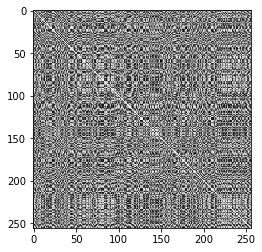

In [294]:
import numpy as np
import matplotlib.pyplot as plt
plt.imshow(c, cmap='gray')

In [90]:
on_diag = tf.linalg.diag_part(c) + (-1)
np.set_printoptions(threshold=np.inf)  # Para que no se recorte la visualización
print(on_diag)

tf.Tensor(
[0.97144055 0.97859454 0.95727694 0.98503435 0.96831226 0.9646337
 0.9778224  0.94700074 0.9582859  0.9947611  0.8791063  0.98882794
 0.7312075  0.9779346  0.9829756  0.9597999  0.9929656  0.9710511
 0.9731817  0.9176209  0.96902776 0.983577   0.96290374 0.9682181
 0.9870937  0.9809854  0.98451185 0.984843   0.9826971  0.9682927
 0.91329646 0.9882567  0.9419277  0.9225528  0.9497645  0.9777461
 0.96953845 0.979527   0.974707   0.9350703  0.9892154  0.9830501
 0.9857837  0.97210824 0.9593022  0.97953236 0.98436904 0.9470885
 0.97939086 0.98158944 0.9339106  0.98093724 0.9682206  0.98230624
 0.9520724  0.99212277 0.9720075  0.9734478  0.9783982  0.9852879
 0.9770887  0.98456573 0.9942806  0.96607804 0.99356246 0.8675077
 0.99120486 0.92112017 0.97955227 0.9477904  0.9766253  0.99374604
 0.9700458  0.98699594 0.98441875 0.9928458  0.97968805 0.98989916
 0.9669273  0.9827002  0.94481623 0.9646394  0.98939526 0.99205494
 0.98654664 0.97253704 0.9903904  0.9731386  0.9811859  0.99

In [295]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.metrics import AUC, Accuracy, Precision, Recall, MeanIoU, MeanAbsoluteError
from skimage.measure import label

# Definición de la función de pérdida personalizada 'bce_dice_loss'
def bce_dice_loss(y_true, y_pred):
    # Implementación de tu función de pérdida
    pass

# Definición de las métricas
################### METRICS ###################
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = label(y_true_in > 0.5)
    y_pred = label(y_pred_in > 0.5)
    
    true_objects = len(np.unique(labels))
    pred_objects = len(np.unique(y_pred))

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    union = area_true + area_pred - intersection

    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    iou = intersection / union

    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1
        false_positives = np.sum(matches, axis=0) == 0
        false_negatives = np.sum(matches, axis=1) == 0
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    value = 0.
    for batch in range(batch_size):
        value = value + iou_metric(y_true_in[batch], y_pred_in[batch])
    return value/batch_size

def my_iou_metric(label, pred):
    metric_value = tf.py_function(iou_metric_batch, [label, pred], tf.float32)
    return metric_value

def my_iou_metric_loss(label, pred):
    loss = 1 - tf.py_function(iou_metric_batch, [label, pred], tf.float32)
    loss.set_shape((None,))
    return loss

def dice_coeff(y_true, y_pred):
    smooth = 1.
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)
    return score

def haud_dist(y_true, y_pred):
    y_true = np.squeeze(y_true)
    y_pred = np.squeeze(y_pred)
    return hausdorff_distance(y_true, y_pred)

def haud_dist_batch(y_true, y_pred):
    if len(y_true.shape) == 2:
        return haud_dist(y_true, y_pred)
    else:
        batch_size = y_true.shape[0]
    hd = 0.
    for batch in range(batch_size):
        hd = hd + haud_dist(y_true[batch], y_pred[batch])
    return hd / batch_size

def my_haud_dist(label, pred):
    metric_value = tf.py_function(haud_dist_batch, [label, pred], tf.float32)
    return metric_value

def evalResult(gt, pred, target_size=(256, 256), flag_multi_class=False, num_class=2):
    gt = np.squeeze(gt)
    pred = np.squeeze(pred)
    
    acc = Accuracy()
    acc.update_state(np.squeeze(gt), np.squeeze(pred))
    r_acc = acc.result().numpy()
    
    pr = Precision()
    pr.update_state(np.squeeze(gt), np.squeeze(pred))
    r_pr = pr.result().numpy()
    
    rc = Recall()
    rc.update_state(np.squeeze(gt), np.squeeze(pred))
    r_rc = rc.result().numpy()
    
    mi = MeanIoU(num_class)
    mi.update_state(np.squeeze(gt), np.squeeze(pred))
    r_mi = mi.result().numpy()
    
    dc = 0.
    for img in range(gt.shape[0]):
        dc = dc + dice_coeff(gt[img], pred[img]).numpy()
    dc = dc / gt.shape[0]
       
    miou = iou_metric_batch(gt, pred)
    
    mae = MeanAbsoluteError()
    r_mae = mae(np.squeeze(gt), np.squeeze(pred)).numpy()

    auroc = AUC()
    auroc.update_state(np.squeeze(gt), np.squeeze(pred))
    r_auroc = auroc.result().numpy()

    print("Accuracy=", r_acc, "Precision=", r_pr, "Recall=", r_rc, "MeanIoU=", r_mi, 
          "DiceCoefficient=", dc, "MyIoU=", miou, "MAE=", r_mae, "AUROC=", r_auroc)

In [296]:
################### LOSS FUNCTIONS ###################
def focal_loss(target_tensor, prediction_tensor, weights=None, alpha=0.25, gamma=2):
    sigmoid_p = tf.nn.sigmoid(prediction_tensor)
    zeros = array_ops.zeros_like(sigmoid_p, dtype=sigmoid_p.dtype)
    
    # For poitive prediction, only need consider front part loss, back part is 0;
    # target_tensor > zeros <=> z=1, so poitive coefficient = z - p.
    pos_p_sub = array_ops.where(target_tensor > zeros, target_tensor - sigmoid_p, zeros)
    
    # For negative prediction, only need consider back part loss, front part is 0;
    # target_tensor > zeros <=> z=1, so negative coefficient = 0.
    neg_p_sub = array_ops.where(target_tensor > zeros, zeros, sigmoid_p)
    per_entry_cross_ent = - alpha * (pos_p_sub ** gamma) * tf.math.log(tf.clip_by_value(sigmoid_p, 1e-8, 1.0))                           - (1 - alpha) * (neg_p_sub ** gamma) * tf.math.log(tf.clip_by_value(1.0 - sigmoid_p, 1e-8, 1.0))
    return tf.reduce_sum(per_entry_cross_ent)

def mean_iou_loss(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.compat.v1.to_int32(y_pred > t)
        score, up_opt = tf.compat.v1.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return -tf.math.log(K.mean(K.stack(prec), axis=0))

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

def bce_dice_loss(y_true, y_pred):
    loss = 0.4*categorical_crossentropy(y_true, y_pred) + 0.6*dice_loss(y_true, y_pred)
    return loss

def bce_dice_loss2(y_true, y_pred):
    fl = focal_loss(y_true, y_pred, gamma=5)
    loss = 0.2*categorical_crossentropy(y_true, y_pred) + 0.3*dice_loss(y_true, y_pred) + 0.5*fl
    return loss

In [93]:
################### CALLBACKS ###################
log_path = "logs/"
keyname = "BT-Unet"
cur_date = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tb_log_dir = log_path + "fit/" + keyname + '_' + cur_date 
tensorboard_callback = TensorBoard(log_dir=tb_log_dir, histogram_freq=0)
model_checkpoint = ModelCheckpoint('model_'+keyname+'.hdf5', monitor='loss',verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='loss', verbose=1, patience=20)
#csv_logger = CSVLogger(log_path + keyname + '_' + cur_date + '.log', separator=',', append=False)
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=10)

In [96]:
new_x_train_20 = X_train
new_y_train_20 = y_train
new_x_test = X_test
new_y_test = y_test

In [ ]:
print(np.shape(new_x_train_20))
print(np.shape(new_y_train_20))
print(np.shape(new_x_test))
print(np.shape(new_y_test))

In [ ]:
np.shape(X_train)

In [ ]:
np.shape(y_train)

In [ ]:
backbone = tf.keras.Model(
        barlow_twins.input, barlow_twins.layers[-9].output
    )
backbone.output

In [ ]:
new_skip_connections = [backbone.get_layer(index=0).output, # This will vary depending on the encoder structure
                            backbone.get_layer(index=4).output, 
                            backbone.get_layer(index=12).output, 
                            backbone.get_layer(index=58).output]

new_skip_connections

In [ ]:
def decoder(inputs, skip_connections):
    num_filters = [128, 64, 32, 16]
    skip_connections.reverse()
    x = inputs
    batch_norm = True
    
    for i, f in enumerate(num_filters):
        
        x_up = UpSampling2D(size=(2, 2), data_format="channels_last")(x)
        x_att = concatenate([x_up, skip_connections[i]], axis=-1)
        
        x = double_conv_layer(x_att, 3, f, 0.1, True)
    return x

In [ ]:
def output(inputs):
    x = Conv2D(1, kernel_size=(1,1))(inputs)
    x = BatchNormalization()(x)
    x = Activation('sigmoid')(x)
    
    return x

In [ ]:
################### CALLBACKS ###################
log_path = "logs/"
keyname = "BT-Unet"
cur_date = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tb_log_dir = log_path + "fit/" + keyname + '_' + cur_date 
tensorboard_callback = TensorBoard(log_dir=tb_log_dir, histogram_freq=0)
model_checkpoint = ModelCheckpoint('model_'+keyname+'.hdf5', monitor='loss',verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='loss', verbose=1, patience=20)
#csv_logger = CSVLogger(log_path + keyname + '_' + cur_date + '.log', separator=',', append=False)
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=10)

In [ ]:
def double_conv_layer(x, filter_size, size, dropout, batch_norm=False):
    # axis: es el numero de minilotes para la convolución separable, como las imagenes son RGB.
    axis = 3
    conv = SeparableConv2D(size, (filter_size, filter_size), padding='same')(x)
    if batch_norm is True:
        conv = BatchNormalization(axis=axis)(conv)
    conv = Activation('relu')(conv)
    conv = SeparableConv2D(size, (filter_size, filter_size), padding='same')(conv)
    if batch_norm is True:
        conv = BatchNormalization(axis=axis)(conv)
    conv = Activation('relu')(conv)
    if dropout > 0:
        conv = Dropout(dropout)(conv)

    shortcut = Conv2D(size, kernel_size=(1, 1), padding='same')(x)
    if batch_norm is True:
        shortcut = BatchNormalization(axis=axis)(shortcut)

    res_path = add([shortcut, conv])
    return res_path

In [ ]:
def decoder(inputs, skip_connections):
    num_filters = [128, 64, 32, 16]
    skip_connections.reverse()
    x = inputs
    batch_norm = True
    
    for i, f in enumerate(num_filters):
        
        x_up = UpSampling2D(size=(2, 2), data_format="channels_last")(x)
        x_att = concatenate([x_up, skip_connections[i]], axis=-1)
        
        x = double_conv_layer(x_att, 3, f, 0.1, True)
    return x

In [ ]:
np.shape(new_x_train_20)

In [ ]:
np.shape(new_y_train_20)

In [ ]:
np.shape(new_x_test)

In [ ]:
np.shape(new_y_test)

In [ ]:
################### TRAINING ###################
new_x_train_20 = X_train
new_y_train_20 = y_train
new_x_test = X_test
new_y_test = y_test

model = None # Clearing the NN.
backbone = tf.keras.Model(
        barlow_twins.input, barlow_twins.layers[-9].output
    )
    
new_skip_connections = [backbone.get_layer(index=0).output, # This will vary depending on the encoder structure
                            backbone.get_layer(index=4).output, 
                            backbone.get_layer(index=12).output, 
                            backbone.get_layer(index=58).output]
backbone.trainable=True
x = backbone.output
x = decoder(x, new_skip_connections)
outputs = output(x)
model = Model(barlow_twins.input, outputs)

model.compile(
        loss=bce_dice_loss,
        optimizer=Adam(),
        metrics=['accuracy', Precision(), MeanIoU(num_classes=2), Recall(), dice_coeff, MeanAbsoluteError(), my_iou_metric, AUC()]
       )

callbacks = [
            model_checkpoint,
            reduce_lr,
            #csv_logger,
            tensorboard_callback,
            early_stopping
        ]

results = model.fit(new_x_train_20, new_y_train_20, batch_size=8, epochs=100, validation_data=(new_x_test, new_y_test), callbacks=callbacks)
model.save("barlow_twins_DenseNet121UNET_VFD.h5")

In [298]:
cd /home/student15

/home/student15


In [299]:
from tensorflow.keras.models import load_model

model = load_model("barlow_twins_DenseNet121UNET.h5", custom_objects={'bce_dice_loss': bce_dice_loss, 'Precision': Precision, 'MeanIoU': MeanIoU, 'Recall': Recall, 'dice_coeff': dice_coeff, 'MeanAbsoluteError': MeanAbsoluteError, 'my_iou_metric': my_iou_metric})

In [200]:
from tensorflow.keras.models import load_model

model = load_model("barlow_twins_DenseNet121UNET_V27_sinD.h5", custom_objects={'bce_dice_loss': bce_dice_loss, 'Precision': Precision, 'MeanIoU': MeanIoU, 'Recall': Recall, 'dice_coeff': dice_coeff, 'MeanAbsoluteError': MeanAbsoluteError, 'my_iou_metric': my_iou_metric})

1/1 [==============================] - 6s 6s/step
image_test_1
Accuracy= 0.6818695 Precision= 1.0 Recall= 0.70652074 MeanIoU= 0.7664343 DiceCoefficient= 0.8724914910271764 MyIoU= 0.44396662523143976 MAE= 0.19924383
None
image_test_2
Accuracy= 0.6722107 Precision= 0.9997829 Recall= 0.70310783 MeanIoU= 0.742113 DiceCoefficient= 0.8636259357444942 MyIoU= 0.4363415280875494 MAE= 0.20903488
None
image_test_3
Accuracy= 0.67884827 Precision= 0.9995681 Recall= 0.7069263 MeanIoU= 0.7590075 DiceCoefficient= 0.8723353142850101 MyIoU= 0.457456849854598 MAE= 0.20119911
None


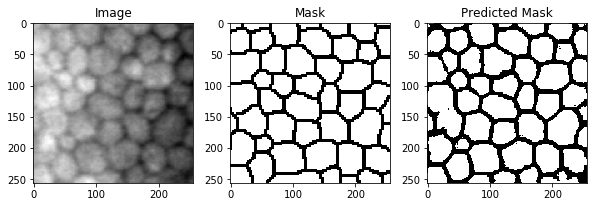

<Figure size 432x288 with 0 Axes>

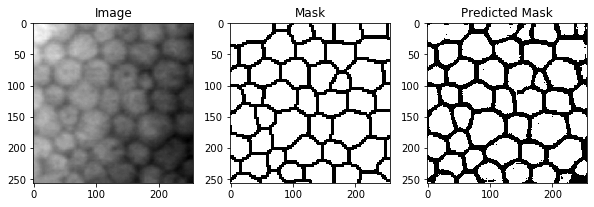

<Figure size 432x288 with 0 Axes>

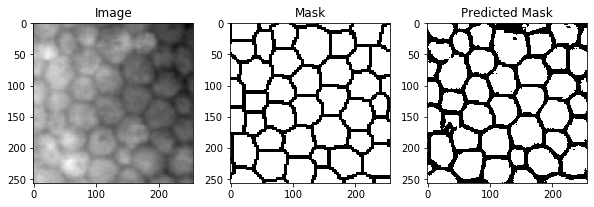

<Figure size 432x288 with 0 Axes>

In [304]:
    ################### EVALUATION ###################
    #model.load_weights('model_'+keyname+'.hdf5')

    preds = model.predict(X_val_patch)

    gt_val_patch = y_val_patch.astype(np.float32)

    preds_t = (preds > 0.81).astype(np.float32)

    #evalResult(gt_val_patch, preds_t)
    print("image_test_1")
    print(evalResult(gt_val_patch[1], preds_t[1]))
    print("image_test_2")
    print(evalResult(gt_val_patch[2], preds_t[2]))
    print("image_test_3")
    print(evalResult(gt_val_patch[3], preds_t[3]))

    x=0
    xx = [1,2,3]
    key_code=datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    for i in range(3):
        plt.figure(figsize=(10,10))
        #ix = random.randint(0, len(preds_train))
        ix = xx[i]
        
        #ix = 58
        plt.subplot(3,3,x+1)
        XX_val_patch = X_val_patch[:,:,:,0]
        plt.imshow(XX_val_patch[ix], cmap='gray')
        plt.title('Image')

        plt.subplot(3,3,x+2)
        m=y_val_patch[ix].astype('uint8')
        m= np.reshape(m, (256,256))
        plt.imshow(m, cmap='gray')
        plt.title('Mask')

        plt.subplot(3,3,x+3)
        s=preds_t[ix].astype('uint8')
        s= np.reshape(s, (256,256))
        plt.imshow(s, cmap='gray')
        #imshow(preds_t[ix])
        plt.title('Predicted Mask')
        plt.show()
        
        plt.savefig('result'+key_code+'.png')
        x = x+3

1/1 [==============================] - 6s 6s/step
image_test_4
Accuracy= 0.6726227 Precision= 0.99978465 Recall= 0.70882887 MeanIoU= 0.7476363 DiceCoefficient= 0.8694709104020149 MyIoU= 0.44339186555121735 MAE= 0.20482388
None
image_test_5
Accuracy= 0.67359924 Precision= 0.99987185 Recall= 0.71483535 MeanIoU= 0.7093277 DiceCoefficient= 0.8666950734332204 MyIoU= 0.41104072311941064 MAE= 0.21021058
None
image_test_6
Accuracy= 0.47631836 Precision= 0.99941546 Recall= 0.52222055 MeanIoU= 0.39615116 DiceCoefficient= 0.686536064138636 MyIoU= 0.13196985442445794 MAE= 0.43911162
None


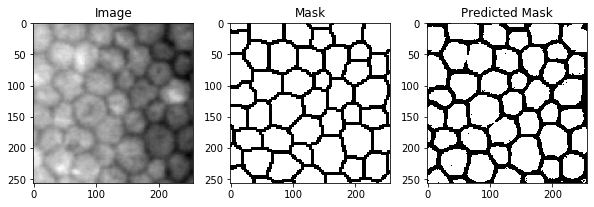

<Figure size 432x288 with 0 Axes>

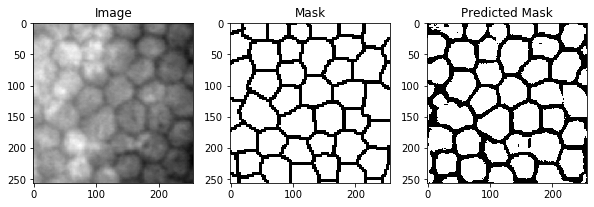

<Figure size 432x288 with 0 Axes>

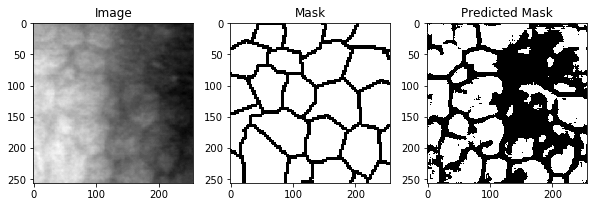

<Figure size 432x288 with 0 Axes>

In [305]:
    ################### EVALUATION ###################
    #model.load_weights('model_'+keyname+'.hdf5')

    preds = model.predict(X_val_patch)

    gt_val_patch = y_val_patch.astype(np.float32)

    preds_t = (preds > 0.81).astype(np.float32)

    #evalResult(gt_val_patch, preds_t)
    print("image_test_4")
    print(evalResult(gt_val_patch[4], preds_t[4]))
    print("image_test_5")
    print(evalResult(gt_val_patch[5], preds_t[5]))
    print("image_test_6")
    print(evalResult(gt_val_patch[6], preds_t[6]))

    x=0
    xx = [4,5,6]
    key_code=datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    for i in range(3):
        plt.figure(figsize=(10,10))
        #ix = random.randint(0, len(preds_train))
        ix = xx[i]
        
        #ix = 58
        plt.subplot(3,3,x+1)
        XX_val_patch = X_val_patch[:,:,:,0]
        plt.imshow(XX_val_patch[ix], cmap='gray')
        plt.title('Image')

        plt.subplot(3,3,x+2)
        m=y_val_patch[ix].astype('uint8')
        m= np.reshape(m, (256,256))
        plt.imshow(m, cmap='gray')
        plt.title('Mask')

        plt.subplot(3,3,x+3)
        s=preds_t[ix].astype('uint8')
        s= np.reshape(s, (256,256))
        plt.imshow(s, cmap='gray')
        #imshow(preds_t[ix])
        plt.title('Predicted Mask')
        plt.show()
        
        plt.savefig('result'+key_code+'.png')
        x = x+3

1/1 [==============================] - 6s 6s/step
image_test_7
Accuracy= 0.45108032 Precision= 0.99978065 Recall= 0.4873064 MeanIoU= 0.42299995 DiceCoefficient= 0.6570941162644885 MyIoU= 0.17137578455511535 MAE= 0.4530028
None
image_test_8
Accuracy= 0.6333771 Precision= 0.9860727 Recall= 0.47139698 MeanIoU= 0.58039796 DiceCoefficient= 0.500402716017561 MyIoU= 0.09756721301842726 MAE= 0.3019843
None
image_test_9
Accuracy= 0.65057373 Precision= 0.9998962 Recall= 0.5883634 MeanIoU= 0.59674203 DiceCoefficient= 0.7001122209476307 MyIoU= 0.154142483707853 MAE= 0.28296635
None


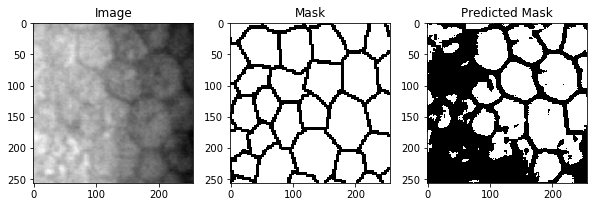

<Figure size 432x288 with 0 Axes>

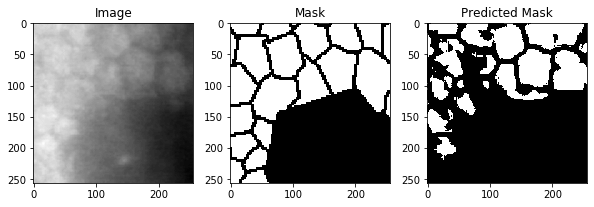

<Figure size 432x288 with 0 Axes>

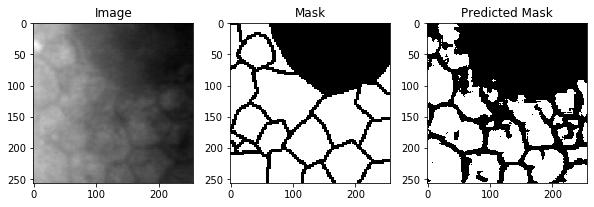

<Figure size 432x288 with 0 Axes>

In [306]:
    ################### EVALUATION ###################
    #model.load_weights('model_'+keyname+'.hdf5')

    preds = model.predict(X_val_patch)

    gt_val_patch = y_val_patch.astype(np.float32)

    preds_t = (preds > 0.81).astype(np.float32)

    #evalResult(gt_val_patch, preds_t)
    print("image_test_7")
    print(evalResult(gt_val_patch[7], preds_t[7]))
    print("image_test_8")
    print(evalResult(gt_val_patch[8], preds_t[8]))
    print("image_test_9")
    print(evalResult(gt_val_patch[9], preds_t[9]))

    x=0
    xx = [7,8,9]
    key_code=datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    for i in range(3):
        plt.figure(figsize=(10,10))
        #ix = random.randint(0, len(preds_train))
        ix = xx[i]
        
        #ix = 58
        plt.subplot(3,3,x+1)
        XX_val_patch = X_val_patch[:,:,:,0]
        plt.imshow(XX_val_patch[ix], cmap='gray')
        plt.title('Image')

        plt.subplot(3,3,x+2)
        m=y_val_patch[ix].astype('uint8')
        m= np.reshape(m, (256,256))
        plt.imshow(m, cmap='gray')
        plt.title('Mask')

        plt.subplot(3,3,x+3)
        s=preds_t[ix].astype('uint8')
        s= np.reshape(s, (256,256))
        plt.imshow(s, cmap='gray')
        #imshow(preds_t[ix])
        plt.title('Predicted Mask')
        plt.show()
        
        plt.savefig('result'+key_code+'.png')
        x = x+3

1/1 [==============================] - 5s 5s/step
image_test_10
Accuracy= 0.6850586 Precision= 0.91836923 Recall= 0.67418873 MeanIoU= 0.62460405 DiceCoefficient= 0.7043696202708816 MyIoU= 0.1950859708867521 MAE= 0.24083173
None
image_test_11
Accuracy= 0.7392578 Precision= 0.99980575 Recall= 0.78575027 MeanIoU= 0.7825092 DiceCoefficient= 0.9147641137242317 MyIoU= 0.6113671665216931 MAE= 0.14127156
None
image_test_12
Accuracy= 0.63697815 Precision= 0.99997616 Recall= 0.6879974 MeanIoU= 0.5496143 DiceCoefficient= 0.8148629865609109 MyIoU= 0.2503346702126 MAE= 0.267129
None


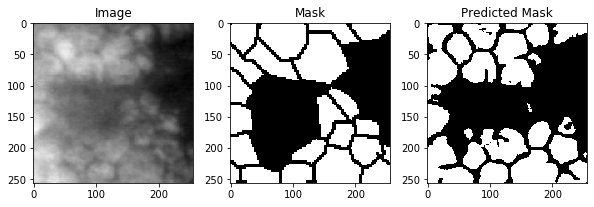

<Figure size 432x288 with 0 Axes>

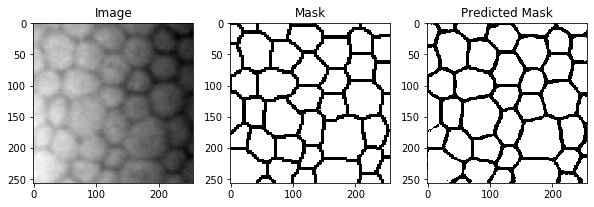

<Figure size 432x288 with 0 Axes>

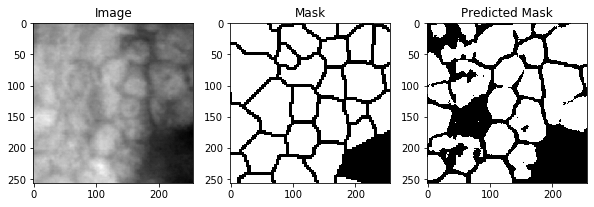

<Figure size 432x288 with 0 Axes>

In [100]:
    ################### EVALUATION ###################
    #model.load_weights('model_'+keyname+'.hdf5')

    preds = model.predict(X_val_patch)

    gt_val_patch = y_val_patch.astype(np.float32)

    preds_t = (preds > 0.75).astype(np.float32)

    #evalResult(gt_val_patch, preds_t)
    print("image_test_10")
    print(evalResult(gt_val_patch[10], preds_t[10]))
    print("image_test_11")
    print(evalResult(gt_val_patch[11], preds_t[11]))
    print("image_test_12")
    print(evalResult(gt_val_patch[12], preds_t[12]))

    x=0
    xx = [10,11,12]
    key_code=datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    for i in range(3):
        plt.figure(figsize=(10,10))
        #ix = random.randint(0, len(preds_train))
        ix = xx[i]
        
        #ix = 58
        plt.subplot(3,3,x+1)
        XX_val_patch = X_val_patch[:,:,:,0]
        plt.imshow(XX_val_patch[ix], cmap='gray')
        plt.title('Image')

        plt.subplot(3,3,x+2)
        m=y_val_patch[ix].astype('uint8')
        m= np.reshape(m, (256,256))
        plt.imshow(m, cmap='gray')
        plt.title('Mask')

        plt.subplot(3,3,x+3)
        s=preds_t[ix].astype('uint8')
        s= np.reshape(s, (256,256))
        plt.imshow(s, cmap='gray')
        #imshow(preds_t[ix])
        plt.title('Predicted Mask')
        plt.show()
        
        plt.savefig('result'+key_code+'.png')
        x = x+3

1/1 [==============================] - 6s 6s/step
image_test_13
Accuracy= 0.5943146 Precision= 0.97385556 Recall= 0.6424298 MeanIoU= 0.5418534 DiceCoefficient= 0.7888139900751412 MyIoU= 0.20339128255497615 MAE= 0.31194013
None
image_test_14
Accuracy= 0.6424408 Precision= 0.9569505 Recall= 0.5645192 MeanIoU= 0.62825525 DiceCoefficient= 0.7281554762739688 MyIoU= 0.23598886139901762 MAE= 0.2779829
None
image_test_15
Accuracy= 0.7910156 Precision= 0.73784447 Recall= 0.5275156 MeanIoU= 0.6293013 DiceCoefficient= 0.5021880304157094 MyIoU= 0.10500434027777789 MAE= 0.18253107
None


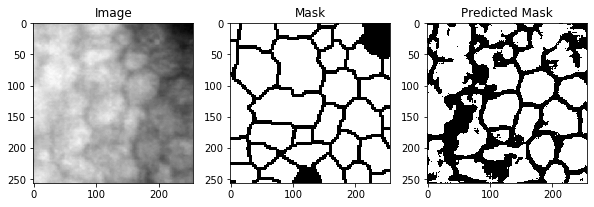

<Figure size 432x288 with 0 Axes>

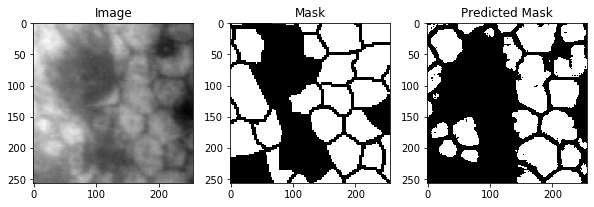

<Figure size 432x288 with 0 Axes>

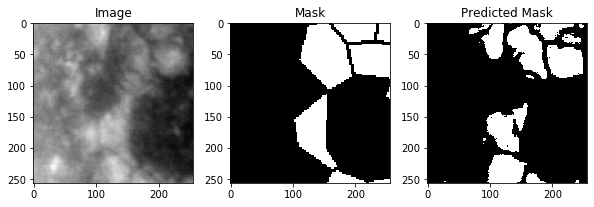

<Figure size 432x288 with 0 Axes>

In [307]:
    ################### EVALUATION ###################
    #model.load_weights('model_'+keyname+'.hdf5')

    preds = model.predict(X_val_patch)

    gt_val_patch = y_val_patch.astype(np.float32)

    preds_t = (preds > 0.81).astype(np.float32)

    #evalResult(gt_val_patch, preds_t)
    print("image_test_13")
    print(evalResult(gt_val_patch[13], preds_t[13]))
    print("image_test_14")
    print(evalResult(gt_val_patch[14], preds_t[14]))
    print("image_test_15")
    print(evalResult(gt_val_patch[15], preds_t[15]))

    x=0
    xx = [13,14,15]
    key_code=datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    for i in range(3):
        plt.figure(figsize=(10,10))
        #ix = random.randint(0, len(preds_train))
        ix = xx[i]
        
        #ix = 58
        plt.subplot(3,3,x+1)
        XX_val_patch = X_val_patch[:,:,:,0]
        plt.imshow(XX_val_patch[ix], cmap='gray')
        plt.title('Image')

        plt.subplot(3,3,x+2)
        m=y_val_patch[ix].astype('uint8')
        m= np.reshape(m, (256,256))
        plt.imshow(m, cmap='gray')
        plt.title('Mask')

        plt.subplot(3,3,x+3)
        s=preds_t[ix].astype('uint8')
        s= np.reshape(s, (256,256))
        plt.imshow(s, cmap='gray')
        #imshow(preds_t[ix])
        plt.title('Predicted Mask')
        plt.show()
        
        plt.savefig('result'+key_code+'.png')
        x = x+3

1/1 [==============================] - 6s 6s/step
image_test_16
Accuracy= 0.66116333 Precision= 0.9150529 Recall= 0.48409247 MeanIoU= 0.6019715 DiceCoefficient= 0.5732329804013716 MyIoU= 0.1637249539018237 MAE= 0.27085066
None
image_test_17
Accuracy= 0.6633911 Precision= 0.96562386 Recall= 0.51666504 MeanIoU= 0.63228405 DiceCoefficient= 0.6829882594756782 MyIoU= 0.24757595867016213 MAE= 0.26443052
None
image_test_18
Accuracy= 0.7775421 Precision= 0.9996929 Recall= 0.79533064 MeanIoU= 0.7260883 DiceCoefficient= 0.910081343492493 MyIoU= 0.5265511723519533 MAE= 0.15187803
None


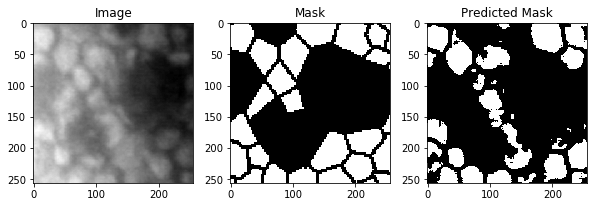

<Figure size 432x288 with 0 Axes>

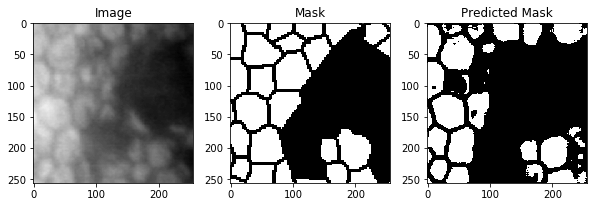

<Figure size 432x288 with 0 Axes>

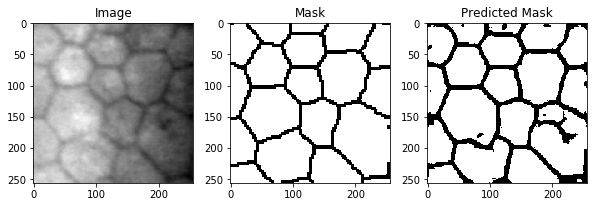

<Figure size 432x288 with 0 Axes>

In [308]:
    ################### EVALUATION ###################
    #model.load_weights('model_'+keyname+'.hdf5')

    preds = model.predict(X_val_patch)

    gt_val_patch = y_val_patch.astype(np.float32)

    preds_t = (preds > 0.81).astype(np.float32)

    #evalResult(gt_val_patch, preds_t)
    print("image_test_16")
    print(evalResult(gt_val_patch[16], preds_t[16]))
    print("image_test_17")
    print(evalResult(gt_val_patch[17], preds_t[17]))
    print("image_test_18")
    print(evalResult(gt_val_patch[18], preds_t[18]))

    x=0
    xx = [16,17,18]
    key_code=datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    for i in range(3):
        plt.figure(figsize=(10,10))
        #ix = random.randint(0, len(preds_train))
        ix = xx[i]
        
        #ix = 58
        plt.subplot(3,3,x+1)
        XX_val_patch = X_val_patch[:,:,:,0]
        plt.imshow(XX_val_patch[ix], cmap='gray')
        plt.title('Image')

        plt.subplot(3,3,x+2)
        m=y_val_patch[ix].astype('uint8')
        m= np.reshape(m, (256,256))
        plt.imshow(m, cmap='gray')
        plt.title('Mask')

        plt.subplot(3,3,x+3)
        s=preds_t[ix].astype('uint8')
        s= np.reshape(s, (256,256))
        plt.imshow(s, cmap='gray')
        #imshow(preds_t[ix])
        plt.title('Predicted Mask')
        plt.show()
        
        plt.savefig('result'+key_code+'.png')
        x = x+3

1/1 [==============================] - 6s 6s/step
image_test_19
Accuracy= 0.7585602 Precision= 0.99992174 Recall= 0.7803984 MeanIoU= 0.6997106 DiceCoefficient= 0.9010659188497812 MyIoU= 0.44999829434888017 MAE= 0.16719845
None
image_test_20
Accuracy= 0.7564087 Precision= 1.0 Recall= 0.77334046 MeanIoU= 0.72099566 DiceCoefficient= 0.8978544226847589 MyIoU= 0.4093025575705953 MAE= 0.16881493
None
image_test_21
Accuracy= 0.7477417 Precision= 0.99998 Recall= 0.7632403 MeanIoU= 0.7470177 DiceCoefficient= 0.897043997887522 MyIoU= 0.5130916804549616 MAE= 0.1698995
None


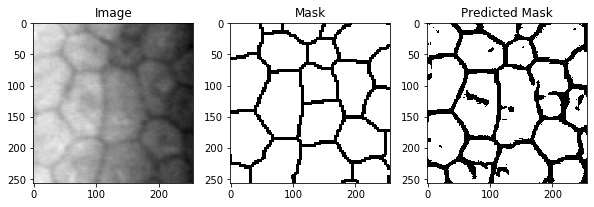

<Figure size 432x288 with 0 Axes>

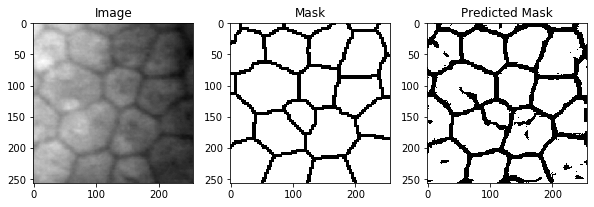

<Figure size 432x288 with 0 Axes>

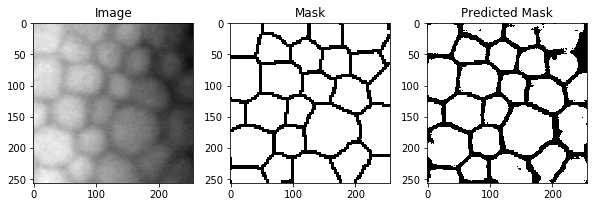

<Figure size 432x288 with 0 Axes>

In [309]:
    ################### EVALUATION ###################
    #model.load_weights('model_'+keyname+'.hdf5')

    preds = model.predict(X_val_patch)

    gt_val_patch = y_val_patch.astype(np.float32)

    preds_t = (preds > 0.81).astype(np.float32)

    #evalResult(gt_val_patch, preds_t)
    print("image_test_19")
    print(evalResult(gt_val_patch[19], preds_t[19]))
    print("image_test_20")
    print(evalResult(gt_val_patch[20], preds_t[20]))
    print("image_test_21")
    print(evalResult(gt_val_patch[21], preds_t[21]))

    x=0
    xx = [19,20,21]
    key_code=datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    for i in range(3):
        plt.figure(figsize=(10,10))
        #ix = random.randint(0, len(preds_train))
        ix = xx[i]
        
        #ix = 58
        plt.subplot(3,3,x+1)
        XX_val_patch = X_val_patch[:,:,:,0]
        plt.imshow(XX_val_patch[ix], cmap='gray')
        plt.title('Image')

        plt.subplot(3,3,x+2)
        m=y_val_patch[ix].astype('uint8')
        m= np.reshape(m, (256,256))
        plt.imshow(m, cmap='gray')
        plt.title('Mask')

        plt.subplot(3,3,x+3)
        s=preds_t[ix].astype('uint8')
        s= np.reshape(s, (256,256))
        plt.imshow(s, cmap='gray')
        #imshow(preds_t[ix])
        plt.title('Predicted Mask')
        plt.show()
        
        plt.savefig('result'+key_code+'.png')
        x = x+3

1/1 [==============================] - 6s 6s/step
image_test_22
Accuracy= 0.71795654 Precision= 1.0 Recall= 0.74781734 MeanIoU= 0.7429196 DiceCoefficient= 0.887949216645211 MyIoU= 0.5256074807142675 MAE= 0.18065873
None
image_test_23
Accuracy= 0.67933655 Precision= 0.9999354 Recall= 0.70849556 MeanIoU= 0.7719469 DiceCoefficient= 0.8733138705138117 MyIoU= 0.47197798698509197 MAE= 0.19900382
None
image_test_24
Accuracy= 0.70529175 Precision= 1.0 Recall= 0.7329824 MeanIoU= 0.7405898 DiceCoefficient= 0.8824003995396197 MyIoU= 0.510279898690974 MAE= 0.19034281
None


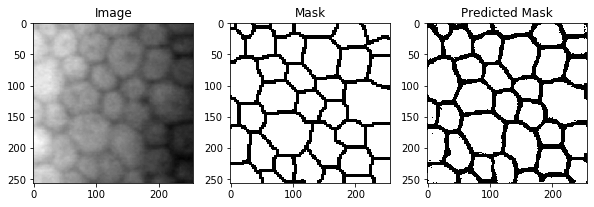

<Figure size 432x288 with 0 Axes>

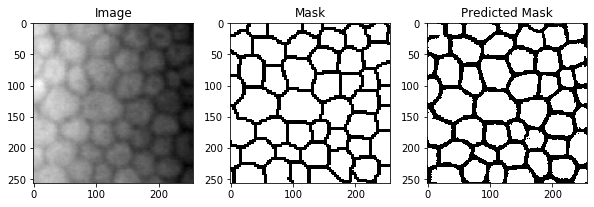

<Figure size 432x288 with 0 Axes>

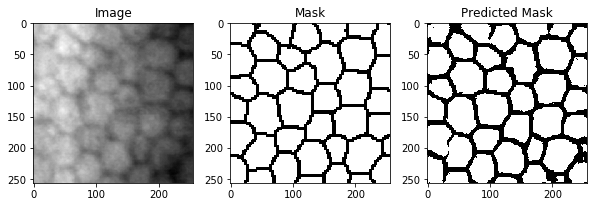

<Figure size 432x288 with 0 Axes>

In [310]:
    ################### EVALUATION ###################
    #model.load_weights('model_'+keyname+'.hdf5')

    preds = model.predict(X_val_patch)

    gt_val_patch = y_val_patch.astype(np.float32)

    preds_t = (preds > 0.81).astype(np.float32)

    #evalResult(gt_val_patch, preds_t)
    print("image_test_22")
    print(evalResult(gt_val_patch[22], preds_t[22]))
    print("image_test_23")
    print(evalResult(gt_val_patch[23], preds_t[23]))
    print("image_test_24")
    print(evalResult(gt_val_patch[24], preds_t[24]))

    x=0
    xx = [22,23,24]
    key_code=datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    for i in range(3):
        plt.figure(figsize=(10,10))
        #ix = random.randint(0, len(preds_train))
        ix = xx[i]
        
        #ix = 58
        plt.subplot(3,3,x+1)
        XX_val_patch = X_val_patch[:,:,:,0]
        plt.imshow(XX_val_patch[ix], cmap='gray')
        plt.title('Image')

        plt.subplot(3,3,x+2)
        m=y_val_patch[ix].astype('uint8')
        m= np.reshape(m, (256,256))
        plt.imshow(m, cmap='gray')
        plt.title('Mask')

        plt.subplot(3,3,x+3)
        s=preds_t[ix].astype('uint8')
        s= np.reshape(s, (256,256))
        plt.imshow(s, cmap='gray')
        #imshow(preds_t[ix])
        plt.title('Predicted Mask')
        plt.show()
        
        plt.savefig('result'+key_code+'.png')
        x = x+3

1/1 [==============================] - 6s 6s/step
image_test_25
Accuracy= 0.6495056 Precision= 0.9943217 Recall= 0.6679498 MeanIoU= 0.599704 DiceCoefficient= 0.7913657859899104 MyIoU= 0.19260323284507538 MAE= 0.26372126
None
image_test_26
Accuracy= 0.5205231 Precision= 0.9903226 Recall= 0.48880976 MeanIoU= 0.48447156 DiceCoefficient= 0.6556222821818665 MyIoU= 0.14000571231643144 MAE= 0.3957395
None
image_test_27
Accuracy= 0.3841095 Precision= 0.97310764 Recall= 0.4199807 MeanIoU= 0.3355839 DiceCoefficient= 0.5872321156784892 MyIoU= 0.12108356946362453 MAE= 0.5315976
None


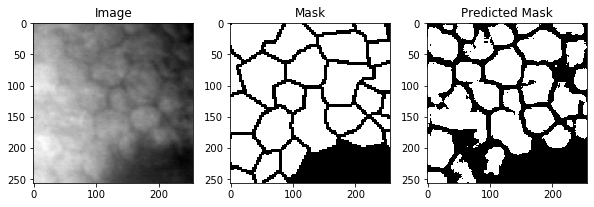

<Figure size 432x288 with 0 Axes>

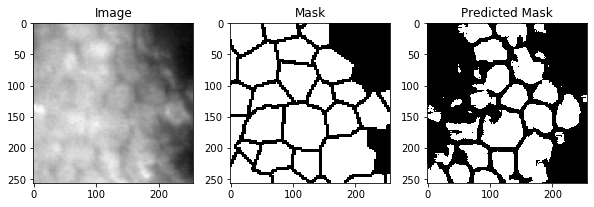

<Figure size 432x288 with 0 Axes>

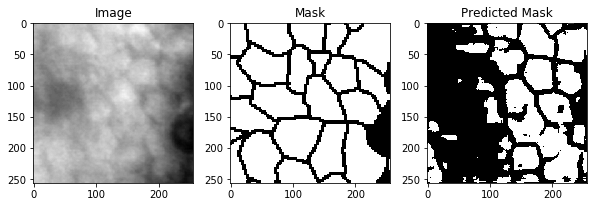

<Figure size 432x288 with 0 Axes>

In [311]:
    ################### EVALUATION ###################
    #model.load_weights('model_'+keyname+'.hdf5')

    preds = model.predict(X_val_patch)

    gt_val_patch = y_val_patch.astype(np.float32)

    preds_t = (preds > 0.81).astype(np.float32)

    #evalResult(gt_val_patch, preds_t)
    print("image_test_25")
    print(evalResult(gt_val_patch[25], preds_t[25]))
    print("image_test_26")
    print(evalResult(gt_val_patch[26], preds_t[26]))
    print("image_test_27")
    print(evalResult(gt_val_patch[27], preds_t[27]))

    x=0
    xx = [25,26,27]
    key_code=datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    for i in range(3):
        plt.figure(figsize=(10,10))
        #ix = random.randint(0, len(preds_train))
        ix = xx[i]
        
        #ix = 58
        plt.subplot(3,3,x+1)
        XX_val_patch = X_val_patch[:,:,:,0]
        plt.imshow(XX_val_patch[ix], cmap='gray')
        plt.title('Image')

        plt.subplot(3,3,x+2)
        m=y_val_patch[ix].astype('uint8')
        m= np.reshape(m, (256,256))
        plt.imshow(m, cmap='gray')
        plt.title('Mask')

        plt.subplot(3,3,x+3)
        s=preds_t[ix].astype('uint8')
        s= np.reshape(s, (256,256))
        plt.imshow(s, cmap='gray')
        #imshow(preds_t[ix])
        plt.title('Predicted Mask')
        plt.show()
        
        plt.savefig('result'+key_code+'.png')
        x = x+3

In [109]:
np.shape(preds_t[29])

(256, 256, 1)

In [ ]:
img = XX_val_patch[9]
img = unsharp_mask(img, radius=15, amount=1)
plt.imshow(img, cmap='gray')
print(np.shape(img))

In [ ]:
image_label_overlay1 = label2rgb(preds_t[9].astype('uint8')[:,:,0], 
                                image = img, 
                                bg_label = 1,
                                colors = ('chartreuse', 'black'))

plt.imshow(image_label_overlay1)

In [ ]:
img = unsharp_mask(XX_val_patch[9], radius=3, amount=1)
plt.imshow(img, cmap='gray')
s=preds_t[9].astype('uint8')
kernel = np.ones((3, 3), dtype=np.uint8)
eroded_image = cv.erode(s, kernel, iterations=2)
eroded_image = cv.dilate(eroded_image, kernel, iterations=3)
image_label_overlay1 = label2rgb(eroded_image, 
                                image = img, 
                                bg_label = 2,
                                colors = ('chartreuse', 'black'))

plt.imshow(image_label_overlay1)

In [ ]:
from skimage import io, filters, feature
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
import cv2


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from skimage.filters import sobel
from skimage.measure import label
from skimage.segmentation import slic, join_segmentations, watershed
from skimage.color import label2rgb
from skimage import data

In [ ]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
from skimage import io
from skimage.filters import unsharp_mask
from skimage import data
from skimage import exposure

In [ ]:
s=preds_t[9].astype('uint8')
eroded_image=s
plt.imshow(eroded_image, cmap='gray')
valores_unicos = np.unique(s)
print(valores_unicos)

In [ ]:
s=preds_t[9].astype('uint8')
kernel = np.ones((3, 3), dtype=np.uint8)
eroded_image = cv.erode(s, kernel, iterations=2)
eroded_image = cv.dilate(eroded_image, kernel, iterations=3)
plt.imshow(eroded_image, cmap='gray')

In [ ]:
s=preds_t[9].astype('uint8')
markers1= np.stack((s[:,:,0],)*3, axis=-1)
markers1 = markers1.astype(np.uint8)
cell_mask_gray = cv.cvtColor(markers1, cv.COLOR_BGR2GRAY)
ret, cells2 = cv.threshold(cell_mask_gray,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
valores_unicos = np.unique(cells2)
print(valores_unicos)
plt.imshow(cells2, cmap='gray') 

In [ ]:
# noise removal
kernel = np.ones((3,3),np.uint8)
# sure background area
sure_bg = np.array([[0 for i in range(eroded_image.shape[1])] for j in range(eroded_image.shape[0])])
# Finding sure foreground area
dist_transform = cv.distanceTransform(cells2.astype(np.uint8),cv.DIST_L2,5)

ret, sure_fg = cv.threshold(dist_transform,0.1*dist_transform.max(),255,0)
# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = 255 - sure_fg

In [ ]:
# Marker labelling
ret, markers = cv.connectedComponents(sure_fg)
# Se agrega uno a todas las etiquetas para que el fondo seguro no sea 0, sino 1
#markers = markers+1
# Ahora, marque la región de desconocido con cero
markers[unknown==255] = 0

In [ ]:
# Definir las imágenes
imagen1 = sure_fg
imagen2 = unknown
imagen3 = sure_bg
imagen4 = dist_transform
imagen5 = markers


# Crear la figura y los subplots con tamaño personalizado
fig, axs = plt.subplots(3, 3, figsize=(12, 12))

# Ajustar el tamaño de las figuras de los subplots
for i in range(3):
    for j in range(3):
        axs[i, j].set_aspect('equal')

# Mostrar las imágenes en los subplots
axs[0, 0].imshow(imagen1)
axs[0, 0].set_title('Sure foreground area')

axs[0, 1].imshow(imagen2)
axs[0, 1].set_title('Unknown')

axs[0, 2].imshow(imagen3)
axs[0, 2].set_title('Sure background area')

axs[1, 0].imshow(imagen4, cmap="gray")
axs[1, 0].set_title('Dist_transform ')

axs[1, 1].imshow(imagen5, cmap="gray")
axs[1, 1].set_title('Markers')


# Ocultar los subplots vacíos
axs[1, 2].axis('off')
axs[2, 0].axis('off')
axs[2, 1].axis('off')
axs[2, 2].axis('off')

In [ ]:
markers1 = np.pad(markers, pad_width=1, mode='constant')
dist_transform = np.pad(sure_bg, pad_width=1, mode='constant')

dist_transform1 =np.stack((dist_transform,)*3, axis=-1)
markers = cv.watershed(dist_transform1.astype(np.uint8),markers1)
print(np.shape(markers))
print(plt.imshow(markers))

In [ ]:
x = (258 - 256) // 2
y = (258 - 256) // 2

# Recortar la imagen
markers = markers[y:y+256, x:x+256]
imagen5 = markers


plt.imshow(markers)
print(markers)

In [ ]:
markers1= np.stack((markers,)*3, axis=-1)
markers1 = markers1.astype(np.uint8)
cell_mask_gray = cv.cvtColor(markers1, cv.COLOR_BGR2GRAY)
ret, cells2 = cv.threshold(cell_mask_gray,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
imagen6 = cells2
plt.imshow(255-cells2, cmap='gray')

In [ ]:
image_label_overlay1 = label2rgb(cells2, 
                                image = img, 
                                bg_label = 0,
                                colors = ('chartreuse', 'black'))

plt.imshow(image_label_overlay1)

In [ ]:
img = XX_val_patch[15]
#img = unsharp_mask(img, radius=3, amount=1)
plt.imshow(img, cmap='gray')
print(np.shape(img))

In [ ]:
cd /home/azken/Sergio/v1

In [ ]:
ls

In [ ]:
from skimage import io
from skimage.filters import unsharp_mask

folder_path = "masks/guttae"
from skimage import data
images1 = []
im_paths2 = glob.glob(folder_path+"/*.png")
im_paths2.sort()
im_paths2

In [ ]:
im_paths2[310]

In [ ]:
c= np.stack((c,)*3, axis=-1)
np.shape(c)

In [ ]:
c=cv2.imread(im_paths2[310], cv2.IMREAD_GRAYSCALE)
c= cv2.resize(c, (256,256))
c= np.stack((c,)*3, axis=-1)
guttae_mask_gray1 = cv.cvtColor(c, cv.COLOR_BGR2GRAY)
ret, c = cv.threshold(guttae_mask_gray1,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)

kernel = np.ones((3, 3), dtype=np.uint8)
eroded_image = cv.erode(c, kernel, iterations=4)
c = cv.dilate(eroded_image, kernel, iterations=9)

plt.imshow(255-c, cmap='gray')
print(np.shape(c))



In [ ]:
valores_unicos = np.unique(c)
print(valores_unicos)

In [ ]:
valores_unicos = np.unique(cells2)
print(valores_unicos)

In [ ]:
plt.imshow(255-c, cmap='gray')

In [ ]:
plt.imshow(255-cells2, cmap='gray')

In [ ]:
image_label_overlay1 = label2rgb(255-c, 
                                image = 255-cells2, 
                                bg_label = 1,
                                colors = ('black', 'white'))

plt.imshow(image_label_overlay1)

In [ ]:
th = 0.9
cells3 = (image_label_overlay1>th)*255
plt.imshow(cells3, cmap='gray')

In [ ]:
np.shape(img)

In [ ]:
image_label_overlay1 = label2rgb(cells3[:,:,0], 
                                image = img, 
                                bg_label = 3,
                                colors = ('chartreuse', 'black'))

plt.imshow(image_label_overlay1)

In [ ]:
plt.imshow(img, cmap='gray')

In [ ]:
image_label_overlay2 = label2rgb(imagen6[:,:,0],
                                image = imagen2,
                                bg_label = 0,
                                colors = ('chartreuse', 'blueviolet'))
imagen7=image_label_overlay2

In [ ]:
c=cv2.imread(im_paths2[250], cv2.IMREAD_GRAYSCALE)
c= cv2.resize(c, (256,256))
guttae_mask_gray1 = cv.cvtColor(c, cv.COLOR_BGR2GRAY)
ret, c = cv.threshold(guttae_mask_gray1,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)

kernel = np.ones((3, 3), dtype=np.uint8)
eroded_image = cv.erode(c, kernel, iterations=4)
c = cv.dilate(eroded_image, kernel, iterations=2)

plt.imshow(255-c, cmap='gray')
print(np.shape(c))

In [ ]:
valores_unicos = np.unique(c)
print(valores_unicos)

In [ ]:
plt.imshow(255-cells2, cmap='gray')

In [ ]:
image_label_overlay1 = label2rgb(c, 
                                image = 255-cells2, 
                                bg_label = 1,
                                colors = ('black', 'white'))

plt.imshow(image_label_overlay1)

In [ ]:
    ################### EVALUATION ###################
    #model.load_weights('model_'+keyname+'.hdf5')

    preds = model.predict(X_val_patch)

    gt_val_patch = y_val_patch.astype(np.float32)

    preds_t = (preds > 0.7).astype(np.float32)

    evalResult(gt_val_patch, preds_t)

    x=0
    xx = [16,17,18]
    key_code=datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    for i in range(3):
        plt.figure(figsize=(10,10))
        #ix = random.randint(0, len(preds_train))
        ix = xx[i]
        #print(ix)
        #ix = 58
        plt.subplot(3,3,x+1)
        XX_val_patch = X_val_patch[:,:,:,0]
        plt.imshow(XX_val_patch[ix], cmap='gray')
        plt.title('Image')

        plt.subplot(3,3,x+2)
        m=y_val_patch[ix].astype('uint8')
        m= np.reshape(m, (256,256))
        plt.imshow(m, cmap='gray')
        plt.title('Mask')

        plt.subplot(3,3,x+3)
        s=preds_t[ix].astype('uint8')
        s= np.reshape(s, (256,256))
        plt.imshow(s, cmap='gray')
        #imshow(preds_t[ix])
        plt.title('Predicted Mask')
        plt.show()
        
        plt.savefig('result'+key_code+'.png')
        x = x+3

In [ ]:
    ################### EVALUATION ###################
    #model.load_weights('model_'+keyname+'.hdf5')

    preds = model.predict(X_val_patch)

    gt_val_patch = y_val_patch.astype(np.float32)

    preds_t = (preds > 0.7).astype(np.float32)

    evalResult(gt_val_patch, preds_t)

    x=0
    xx = [4,5,6]
    key_code=datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    for i in range(3):
        plt.figure(figsize=(10,10))
        #ix = random.randint(0, len(preds_train))
        ix = xx[i]
        #print(ix)
        #ix = 58
        plt.subplot(3,3,x+1)
        XX_val_patch = X_val_patch[:,:,:,0]
        plt.imshow(XX_val_patch[ix], cmap='gray')
        plt.title('Image')

        plt.subplot(3,3,x+2)
        m=y_val_patch[ix].astype('uint8')
        m= np.reshape(m, (256,256))
        plt.imshow(m, cmap='gray')
        plt.title('Mask')

        plt.subplot(3,3,x+3)
        s=preds_t[ix].astype('uint8')
        s= np.reshape(s, (256,256))
        plt.imshow(s, cmap='gray')
        #imshow(preds_t[ix])
        plt.title('Predicted Mask')
        plt.show()
        
        plt.savefig('result'+key_code+'.png')
        x = x+3

In [ ]:
    ################### EVALUATION ###################
    #model.load_weights('model_'+keyname+'.hdf5')

    preds = model.predict(X_val_patch)

    gt_val_patch = y_val_patch.astype(np.float32)

    preds_t = (preds > 0.7).astype(np.float32)

    evalResult(gt_val_patch, preds_t)

    x=0
    xx = [7,8,9]
    key_code=datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    for i in range(3):
        plt.figure(figsize=(10,10))
        #ix = random.randint(0, len(preds_train))
        ix = xx[i]
        #print(ix)
        #ix = 58
        plt.subplot(3,3,x+1)
        XX_val_patch = X_val_patch[:,:,:,0]
        plt.imshow(XX_val_patch[ix], cmap='gray')
        plt.title('Image')

        plt.subplot(3,3,x+2)
        m=y_val_patch[ix].astype('uint8')
        m= np.reshape(m, (256,256))
        plt.imshow(m, cmap='gray')
        plt.title('Mask')

        plt.subplot(3,3,x+3)
        s=preds_t[ix].astype('uint8')
        s= np.reshape(s, (256,256))
        plt.imshow(s, cmap='gray')
        #imshow(preds_t[ix])
        plt.title('Predicted Mask')
        plt.show()
        
        plt.savefig('result'+key_code+'.png')
        x = x+3

In [ ]:
    ################### EVALUATION ###################
    #model.load_weights('model_'+keyname+'.hdf5')

    preds = model.predict(X_val_patch)

    gt_val_patch = y_val_patch.astype(np.float32)

    preds_t = (preds > 0.7).astype(np.float32)

    evalResult(gt_val_patch, preds_t)

    x=0
    xx = [10,11,12]
    key_code=datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    for i in range(3):
        plt.figure(figsize=(10,10))
        #ix = random.randint(0, len(preds_train))
        ix = xx[i]
        #print(ix)
        #ix = 58
        plt.subplot(3,3,x+1)
        XX_val_patch = X_val_patch[:,:,:,0]
        plt.imshow(XX_val_patch[ix], cmap='gray')
        plt.title('Image')

        plt.subplot(3,3,x+2)
        m=y_val_patch[ix].astype('uint8')
        m= np.reshape(m, (256,256))
        plt.imshow(m, cmap='gray')
        plt.title('Mask')

        plt.subplot(3,3,x+3)
        s=preds_t[ix].astype('uint8')
        s= np.reshape(s, (256,256))
        plt.imshow(s, cmap='gray')
        #imshow(preds_t[ix])
        plt.title('Predicted Mask')
        plt.show()
        
        plt.savefig('result'+key_code+'.png')
        x = x+3

In [ ]:
    ################### EVALUATION ###################
    #model.load_weights('model_'+keyname+'.hdf5')

    preds = model.predict(X_val_patch)

    gt_val_patch = y_val_patch.astype(np.float32)

    preds_t = (preds > 0.7).astype(np.float32)

    evalResult(gt_val_patch, preds_t)

    x=0
    xx = [13,14,15]
    key_code=datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    for i in range(3):
        plt.figure(figsize=(10,10))
        #ix = random.randint(0, len(preds_train))
        ix = xx[i]
        #print(ix)
        #ix = 58
        plt.subplot(3,3,x+1)
        XX_val_patch = X_val_patch[:,:,:,0]
        plt.imshow(XX_val_patch[ix], cmap='gray')
        plt.title('Image')

        plt.subplot(3,3,x+2)
        m=y_val_patch[ix].astype('uint8')
        m= np.reshape(m, (256,256))
        plt.imshow(m, cmap='gray')
        plt.title('Mask')

        plt.subplot(3,3,x+3)
        s=preds_t[ix].astype('uint8')
        s= np.reshape(s, (256,256))
        plt.imshow(s, cmap='gray')
        #imshow(preds_t[ix])
        plt.title('Predicted Mask')
        plt.show()
        
        plt.savefig('result'+key_code+'.png')
        x = x+3

In [ ]:
    ################### EVALUATION ###################
    #model.load_weights('model_'+keyname+'.hdf5')

    preds = model.predict(X_val_patch)

    gt_val_patch = y_val_patch.astype(np.float32)

    preds_t = (preds > 0.7).astype(np.float32)

    evalResult(gt_val_patch, preds_t)

    x=0
    xx = [16,17,18]
    key_code=datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    for i in range(3):
        plt.figure(figsize=(10,10))
        #ix = random.randint(0, len(preds_train))
        ix = xx[i]
        #print(ix)
        #ix = 58
        plt.subplot(3,3,x+1)
        XX_val_patch = X_val_patch[:,:,:,0]
        plt.imshow(XX_val_patch[ix], cmap='gray')
        plt.title('Image')

        plt.subplot(3,3,x+2)
        m=y_val_patch[ix].astype('uint8')
        m= np.reshape(m, (256,256))
        plt.imshow(m, cmap='gray')
        plt.title('Mask')

        plt.subplot(3,3,x+3)
        s=preds_t[ix].astype('uint8')
        s= np.reshape(s, (256,256))
        plt.imshow(s, cmap='gray')
        #imshow(preds_t[ix])
        plt.title('Predicted Mask')
        plt.show()
        
        plt.savefig('result'+key_code+'.png')
        x = x+3

In [ ]:
    ################### EVALUATION ###################
    #model.load_weights('model_'+keyname+'.hdf5')

    preds = model.predict(X_test) 

    gt_test = y_test.astype(np.float32)

    preds_t = (preds > 0.9).astype(np.float32)

    evalResult(gt_test, preds_t)

    x=0
    xx = [19,20,21]
    key_code=datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    for i in range(3):
        plt.figure(figsize=(10,10))
        #ix = random.randint(0, len(preds_train))
        ix = xx[i]
        #print(ix)
        #ix = 58
        plt.subplot(3,3,x+1)
        XX_test = X_test[:,:,:,0]
        plt.imshow(XX_test[ix], cmap='gray')
        plt.title('Image')

        plt.subplot(3,3,x+2)
        m=y_test[ix].astype('uint8')
        m= np.reshape(m, (256,256))
        plt.imshow(m, cmap='gray')
        plt.title('Mask')

        plt.subplot(3,3,x+3)
        s=preds_t[ix].astype('uint8')
        s= np.reshape(s, (256,256))
        plt.imshow(s, cmap='gray')
        #imshow(preds_t[ix])
        plt.title('Predicted Mask')
        plt.show()
        
        plt.savefig('result'+key_code+'.png')
        x = x+3

In [ ]:
    ################### EVALUATION ###################
    #model.load_weights('model_'+keyname+'.hdf5')

    preds = model.predict(X_test) 

    gt_test = y_test.astype(np.float32)

    preds_t = (preds > 0.9).astype(np.float32)

    evalResult(gt_test, preds_t)

    x=0
    xx = [22,23,24]
    key_code=datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    for i in range(3):
        plt.figure(figsize=(10,10))
        #ix = random.randint(0, len(preds_train))
        ix = xx[i]
        #print(ix)
        #ix = 58
        plt.subplot(3,3,x+1)
        XX_test = X_test[:,:,:,0]
        plt.imshow(XX_test[ix], cmap='gray')
        plt.title('Image')

        plt.subplot(3,3,x+2)
        m=y_test[ix].astype('uint8')
        m= np.reshape(m, (256,256))
        plt.imshow(m, cmap='gray')
        plt.title('Mask')

        plt.subplot(3,3,x+3)
        s=preds_t[ix].astype('uint8')
        s= np.reshape(s, (256,256))
        plt.imshow(s, cmap='gray')
        #imshow(preds_t[ix])
        plt.title('Predicted Mask')
        plt.show()
        
        plt.savefig('result'+key_code+'.png')
        x = x+3

In [ ]:
   #Deformaciones

In [ ]:
    ################### EVALUATION ###################
    #model.load_weights('model_'+keyname+'.hdf5')

    preds = model.predict(X_val_patch)

    gt_val_patch = y_val_patch.astype(np.float32)

    preds_t = (preds > 0.7).astype(np.float32)

    evalResult(gt_val_patch, preds_t)

    x=0
    xx = [1,2,3]
    key_code=datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    for i in range(3):
        plt.figure(figsize=(10,10))
        #ix = random.randint(0, len(preds_train))
        ix = xx[i]
        #print(ix)
        #ix = 58
        plt.subplot(3,3,x+1)
        XX_val_patch = X_val_patch[:,:,:,0]
        plt.imshow(XX_val_patch[ix], cmap='gray')
        plt.title('Image')

        plt.subplot(3,3,x+2)
        m=y_val_patch[ix].astype('uint8')
        m= np.reshape(m, (256,256))
        plt.imshow(m, cmap='gray')
        plt.title('Mask')

        plt.subplot(3,3,x+3)
        s=preds_t[ix].astype('uint8')
        s= np.reshape(s, (256,256))
        plt.imshow(s, cmap='gray')
        #imshow(preds_t[ix])
        plt.title('Predicted Mask')
        plt.show()
        
        plt.savefig('result'+key_code+'.png')
        x = x+3

In [ ]:
    ################### EVALUATION ###################
    #model.load_weights('model_'+keyname+'.hdf5')

    preds = model.predict(X_val_patch)

    gt_val_patch = y_val_patch.astype(np.float32)

    preds_t = (preds > 0.7).astype(np.float32)

    evalResult(gt_val_patch, preds_t)

    x=0
    xx = [16,17,18]
    key_code=datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    for i in range(3):
        plt.figure(figsize=(10,10))
        #ix = random.randint(0, len(preds_train))
        ix = xx[i]
        #print(ix)
        #ix = 58
        plt.subplot(3,3,x+1)
        XX_val_patch = X_val_patch[:,:,:,0]
        plt.imshow(XX_val_patch[ix], cmap='gray')
        plt.title('Image')

        plt.subplot(3,3,x+2)
        m=y_val_patch[ix].astype('uint8')
        m= np.reshape(m, (256,256))
        plt.imshow(m, cmap='gray')
        plt.title('Mask')

        plt.subplot(3,3,x+3)
        s=preds_t[ix].astype('uint8')
        s= np.reshape(s, (256,256))
        plt.imshow(s, cmap='gray')
        #imshow(preds_t[ix])
        plt.title('Predicted Mask')
        plt.show()
        
        plt.savefig('result'+key_code+'.png')
        x = x+3

In [ ]:
   #Filtro unsharp

In [ ]:
    ################### EVALUATION ###################
    #model.load_weights('model_'+keyname+'.hdf5')

    preds = model.predict(X_val_patch)

    gt_val_patch = y_val_patch.astype(np.float32)

    preds_t = (preds > 0.5).astype(np.float32)

    evalResult(gt_val_patch, preds_t)

    x=0
    xx = [1,2,3]
    key_code=datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    for i in range(3):
        plt.figure(figsize=(10,10))
        #ix = random.randint(0, len(preds_train))
        ix = xx[i]
        #print(ix)
        #ix = 58
        plt.subplot(3,3,x+1)
        XX_val_patch = X_val_patch[:,:,:,0]
        plt.imshow(XX_val_patch[ix], cmap='gray')
        plt.title('Image')

        plt.subplot(3,3,x+2)
        m=y_val_patch[ix].astype('uint8')
        m= np.reshape(m, (256,256))
        plt.imshow(m, cmap='gray')
        plt.title('Mask')

        plt.subplot(3,3,x+3)
        s=preds_t[ix].astype('uint8')
        s= np.reshape(s, (256,256))
        plt.imshow(s, cmap='gray')
        #imshow(preds_t[ix])
        plt.title('Predicted Mask')
        plt.show()
        
        plt.savefig('result'+key_code+'.png')
        x = x+3

In [ ]:
    ################### EVALUATION ###################
    #model.load_weights('model_'+keyname+'.hdf5')

    preds = model.predict(X_val_patch)

    gt_val_patch = y_val_patch.astype(np.float32)

    preds_t = (preds > 0.7).astype(np.float32)

    evalResult(gt_val_patch, preds_t)

    x=0
    xx = [16,17,18]
    key_code=datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    for i in range(3):
        plt.figure(figsize=(10,10))
        #ix = random.randint(0, len(preds_train))
        ix = xx[i]
        #print(ix)
        #ix = 58
        plt.subplot(3,3,x+1)
        XX_val_patch = X_val_patch[:,:,:,0]
        plt.imshow(XX_val_patch[ix], cmap='gray')
        plt.title('Image')

        plt.subplot(3,3,x+2)
        m=y_val_patch[ix].astype('uint8')
        m= np.reshape(m, (256,256))
        plt.imshow(m, cmap='gray')
        plt.title('Mask')

        plt.subplot(3,3,x+3)
        s=preds_t[ix].astype('uint8')
        s= np.reshape(s, (256,256))
        plt.imshow(s, cmap='gray')
        #imshow(preds_t[ix])
        plt.title('Predicted Mask')
        plt.show()
        
        plt.savefig('result'+key_code+'.png')
        x = x+3

In [ ]:
#barlow_twins_DenseNet121UNET_filtergaussian

In [ ]:
    ################### EVALUATION ###################
    #model.load_weights('model_'+keyname+'.hdf5')

    preds = model.predict(X_val_patch)

    gt_val_patch = y_val_patch.astype(np.float32)

    preds_t = (preds > 0.7).astype(np.float32)

    evalResult(gt_val_patch, preds_t)

    x=0
    xx = [1,2,3]
    key_code=datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    for i in range(3):
        plt.figure(figsize=(10,10))
        #ix = random.randint(0, len(preds_train))
        ix = xx[i]
        #print(ix)
        #ix = 58
        plt.subplot(3,3,x+1)
        XX_val_patch = X_val_patch[:,:,:,0]
        plt.imshow(XX_val_patch[ix], cmap='gray')
        plt.title('Image')

        plt.subplot(3,3,x+2)
        m=y_val_patch[ix].astype('uint8')
        m= np.reshape(m, (256,256))
        plt.imshow(m, cmap='gray')
        plt.title('Mask')

        plt.subplot(3,3,x+3)
        s=preds_t[ix].astype('uint8')
        s= np.reshape(s, (256,256))
        plt.imshow(s, cmap='gray')
        #imshow(preds_t[ix])
        plt.title('Predicted Mask')
        plt.show()
        
        plt.savefig('result'+key_code+'.png')
        x = x+3

In [ ]:
    ################### EVALUATION ###################
    #model.load_weights('model_'+keyname+'.hdf5')

    preds = model.predict(X_val_patch)

    gt_val_patch = y_val_patch.astype(np.float32)

    preds_t = (preds > 0.7).astype(np.float32)

    evalResult(gt_val_patch, preds_t)

    x=0
    xx = [16,17,18]
    key_code=datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    for i in range(3):
        plt.figure(figsize=(10,10))
        #ix = random.randint(0, len(preds_train))
        ix = xx[i]
        #print(ix)
        #ix = 58
        plt.subplot(3,3,x+1)
        XX_val_patch = X_val_patch[:,:,:,0]
        plt.imshow(XX_val_patch[ix], cmap='gray')
        plt.title('Image')

        plt.subplot(3,3,x+2)
        m=y_val_patch[ix].astype('uint8')
        m= np.reshape(m, (256,256))
        plt.imshow(m, cmap='gray')
        plt.title('Mask')

        plt.subplot(3,3,x+3)
        s=preds_t[ix].astype('uint8')
        s= np.reshape(s, (256,256))
        plt.imshow(s, cmap='gray')
        #imshow(preds_t[ix])
        plt.title('Predicted Mask')
        plt.show()
        
        plt.savefig('result'+key_code+'.png')
        x = x+3